In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

from collections.abc import Iterable

import numpy as np 
from scipy import interpolate
from scipy.optimize import brent, curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table, Column, vstack, join

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import jianbing
from jianbing import visual
from jianbing import profile
from jianbing import catalog
from jianbing import scatter
from jianbing import wlensing

In [3]:
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format("#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [5]:
# Location of Jianbing directory
jb_dir = jianbing.JB_DIR

topn_dir = jianbing.DATA_DIR
fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

# Additional TopN Tests

- This notebook contains the additional tests requested by the referee.
- There are two sets of TopN tests here:
    1. Whether we can use luminosity of the galaxies instead of the stellar mass for the TopN test
    2. Whether we can use the outskirt mass inferred from the inner region using extrapolation based on Sersic profile fitting.


In [15]:
# Pre-compute results using medium photo-z quality cut
s16a_precompute_med = os.path.join(topn_dir, 'topn_public_s16a_medium_precompute.hdf5')

# HSC massive galaxies
hsc = Table.read(s16a_precompute_med, path='hsc_extra')

hsc_use = hsc[hsc['flag'] > 0]

In [11]:
# Lensing data using medium photo-z quality cut
s16a_lensing = os.path.join(topn_dir, 's16a_weak_lensing_medium.hdf5')

# Random
s16a_rand = Table.read(s16a_lensing, path='random')

# TopN bins
topn_bins = Table.read(os.path.join(jb_dir, 'data', 'bins', 'topn_bins.fits'))

# Tablulated simulation results
sim_cat = Table.read(os.path.join(jb_dir, 'data', 'simulation', 'sim_merge_all_dsig.fits'))

In [16]:
# Available information
print(hsc_use.colnames)

['z', 'ra', 'dec', 'w_sys', 'field', 'index', 'object_id', 'a_g', 'a_r', 'a_i', 'a_z', 'a_y', 'clean_photometry', 'z_spec', 'z_phot', 'z_type', 'z_phot_min', 'z_phot_max', 'gcmodel_mag', 'gcmodel_mag_err', 'rcmodel_mag', 'rcmodel_mag_err', 'icmodel_mag', 'icmodel_mag_err', 'zcmodel_mag', 'zcmodel_mag_err', 'ycmodel_mag', 'ycmodel_mag_err', 'logm_cmod', 'logm_cmod_err', 'lum_5', 'lum_10', 'lum_15', 'lum_25', 'lum_30', 'lum_40', 'lum_50', 'lum_60', 'lum_75', 'lum_100', 'lum_120', 'lum_150', 'lum_max', 'logm_5', 'logm_10', 'logm_15', 'logm_25', 'logm_30', 'logm_40', 'logm_50', 'logm_60', 'logm_75', 'logm_100', 'logm_120', 'logm_150', 'logm_max', 'r20_max', 'r50_max', 'r80_max', 'r90_max', 'r20_120', 'r50_120', 'r80_120', 'r90_120', 'r20_100', 'r50_100', 'r80_100', 'r90_100', 'c82_max', 'c82_120', 'c82_100', 'vdisp_sdss', 'vdisp_err_sdss', 'gama_id', 'logms_gama', 'logms_err_gama', 'logmh_vir_forest', 'logmh_vir_plane', 'logmh_vir_symbol', 'logr_vir_forest', 'sfr_ised', 'sfr_ised_err', 'ta

In [14]:
r_kpc = profile.RKPC_COMMON

r_mask = (r_kpc >= 10.0) & (r_kpc <= 120.)

## Luminosity TopN Tests

- Using i-band luminosity after k-correction
- No evolution correction has been applied


### 10 kpc aperture luminosity 

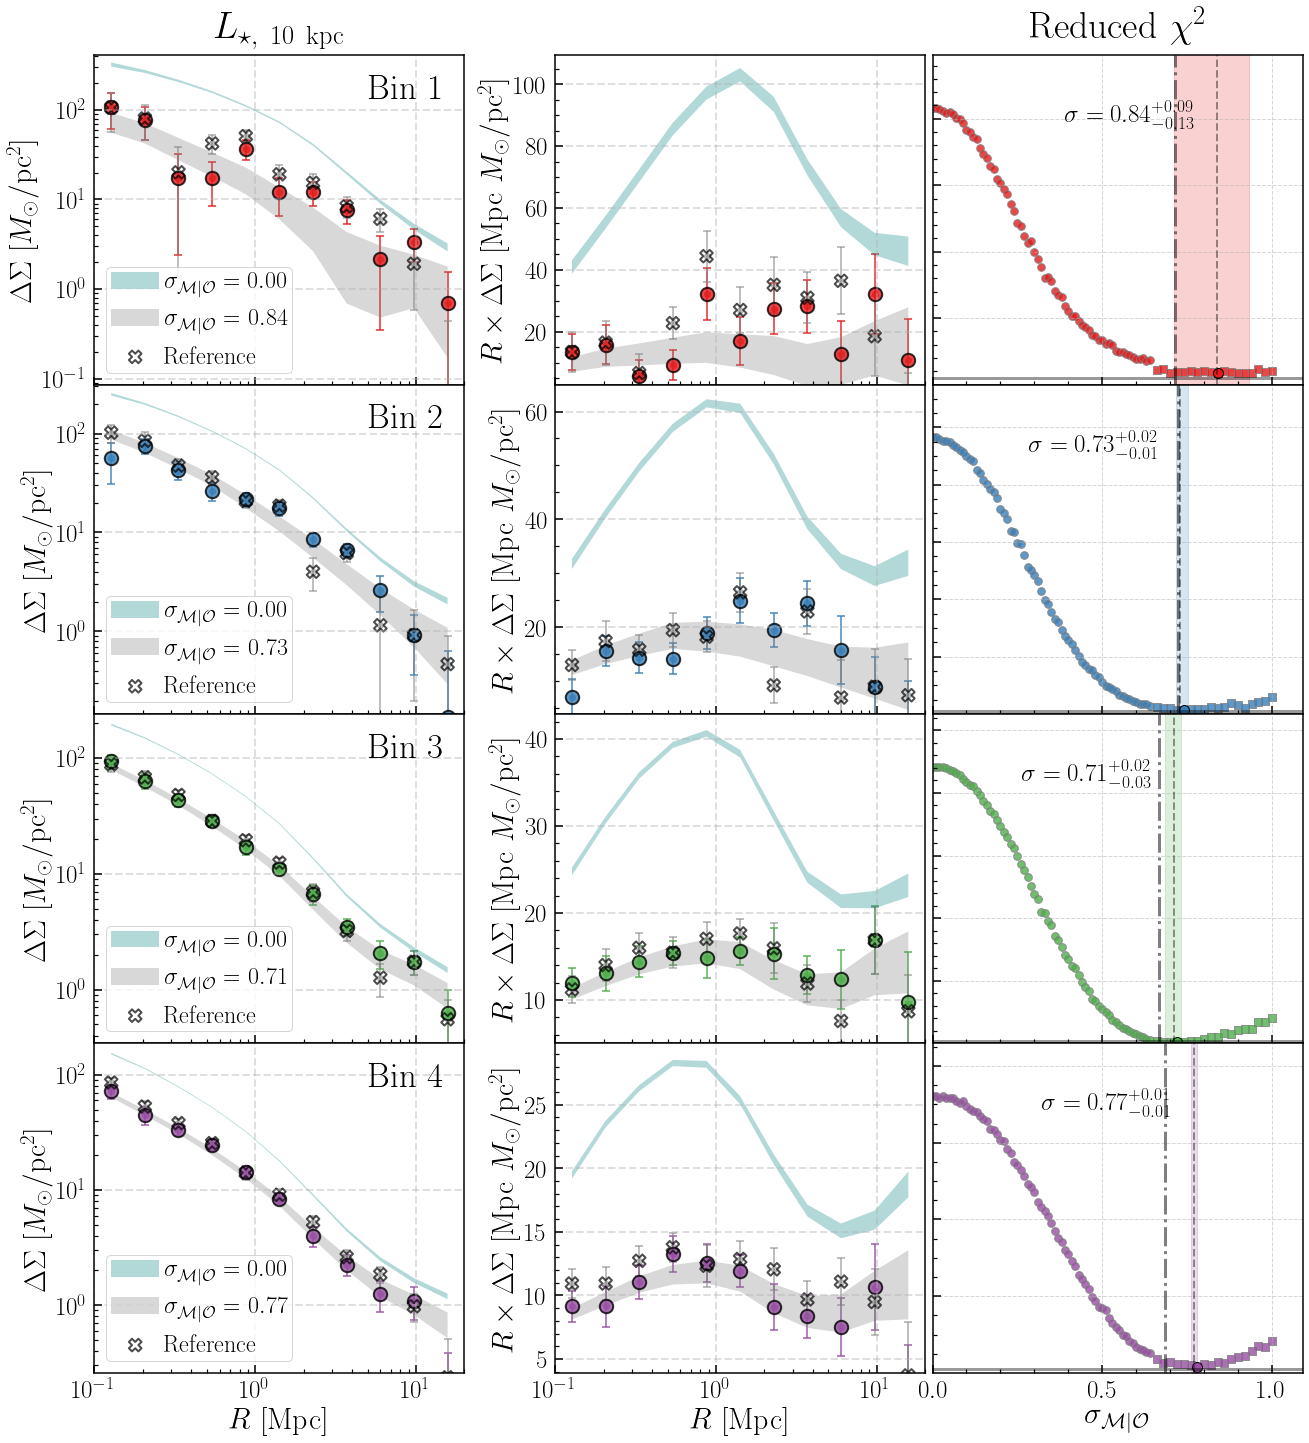

In [28]:
topn_m10 = wlensing.gather_topn_dsigma_profiles(
    hsc_use, s16a_rand, topn_bins, 'logm_10', n_rand=100000, n_boot=200, verbose=False, n_jk=40)

topn_l10 = wlensing.gather_topn_dsigma_profiles(
    hsc_use, s16a_rand, topn_bins, 'lum_10', n_rand=100000, n_boot=200, verbose=False, n_jk=40)

topn_m10_sum = scatter.compare_model_dsigma(
    topn_m10, sim_cat, model_err=True, poly=True, verbose=False)

topn_l10_sum = scatter.compare_model_dsigma(
    topn_l10, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_l10_sum, r'$L_{\star,\ 10\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m10_sum)

### 30 kpc aperture luminosity

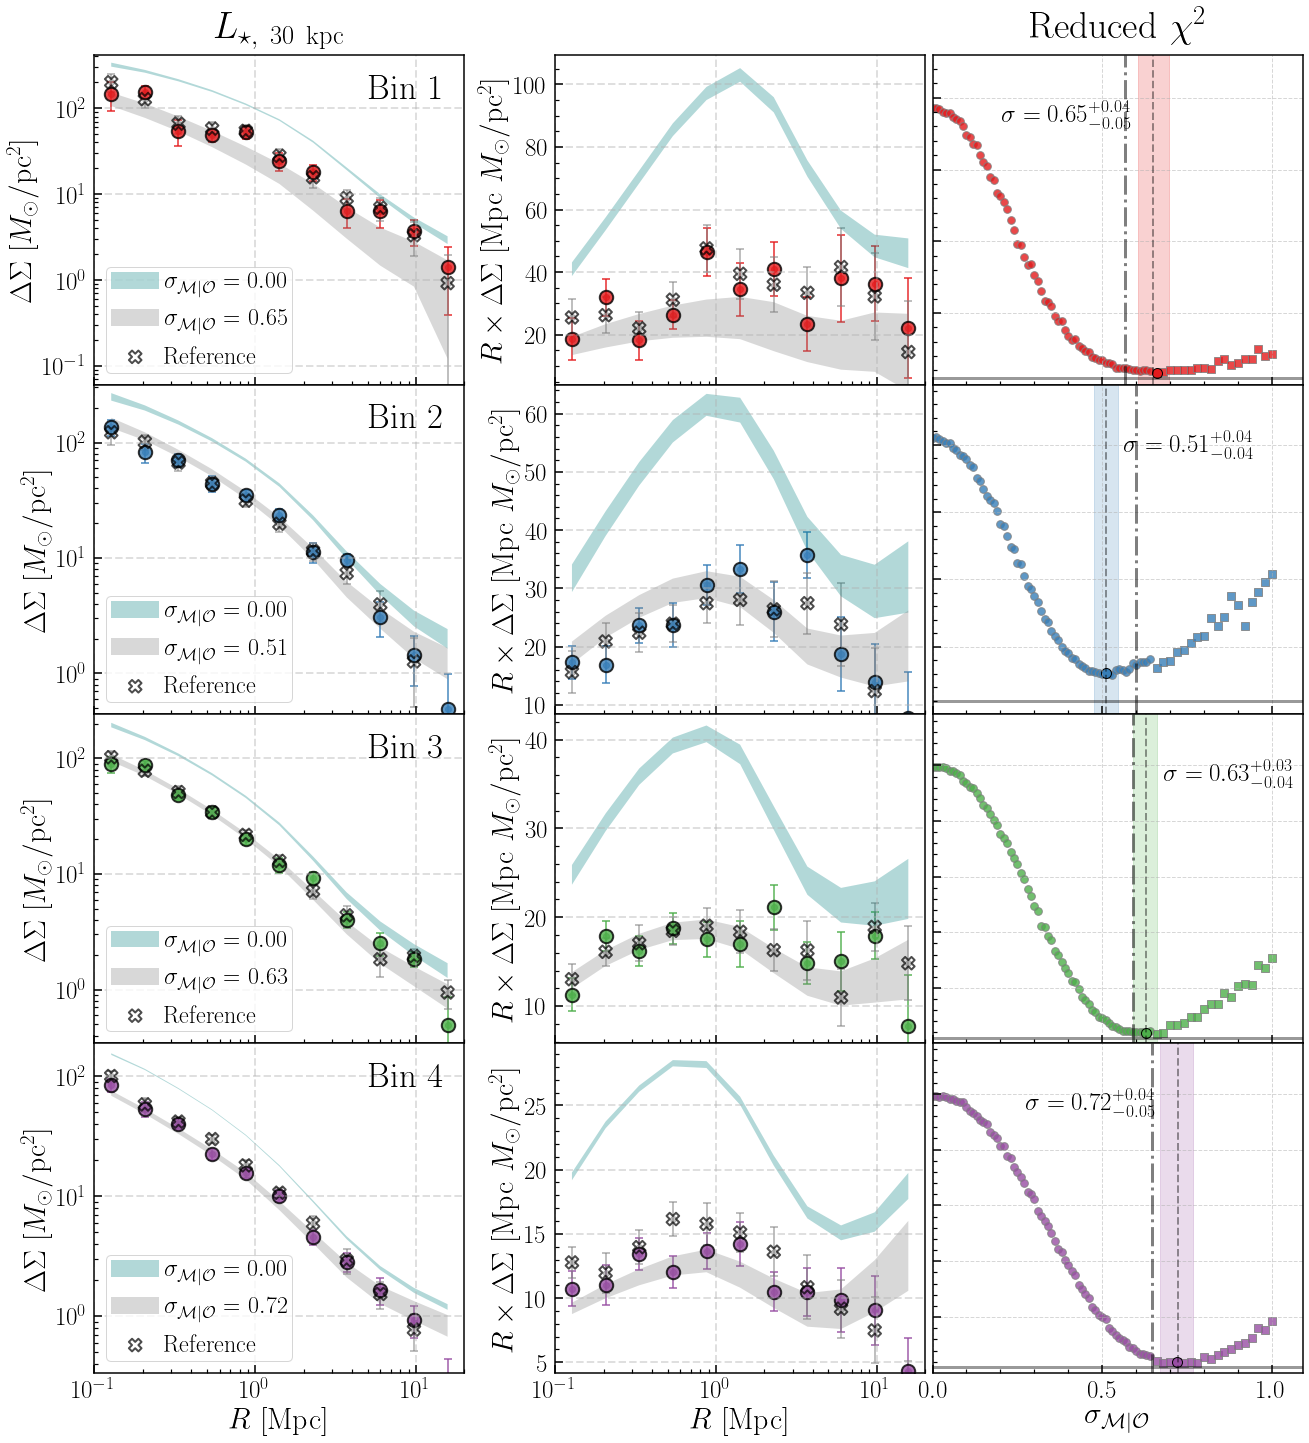

In [29]:
topn_m30 = wlensing.gather_topn_dsigma_profiles(
    hsc_use, s16a_rand, topn_bins, 'logm_30', n_rand=200000, n_boot=200, verbose=False, n_jk=40)

topn_l30 = wlensing.gather_topn_dsigma_profiles(
    hsc_use, s16a_rand, topn_bins, 'lum_30', n_rand=200000, n_boot=200, verbose=False, n_jk=40)

topn_m30_sum = scatter.compare_model_dsigma(
    topn_m30, sim_cat, model_err=True, poly=True, verbose=False)

topn_l30_sum = scatter.compare_model_dsigma(
    topn_l30, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_l30_sum, r'$L_{\star,\ 30\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m30_sum)

### 100 kpc aperture luminosity

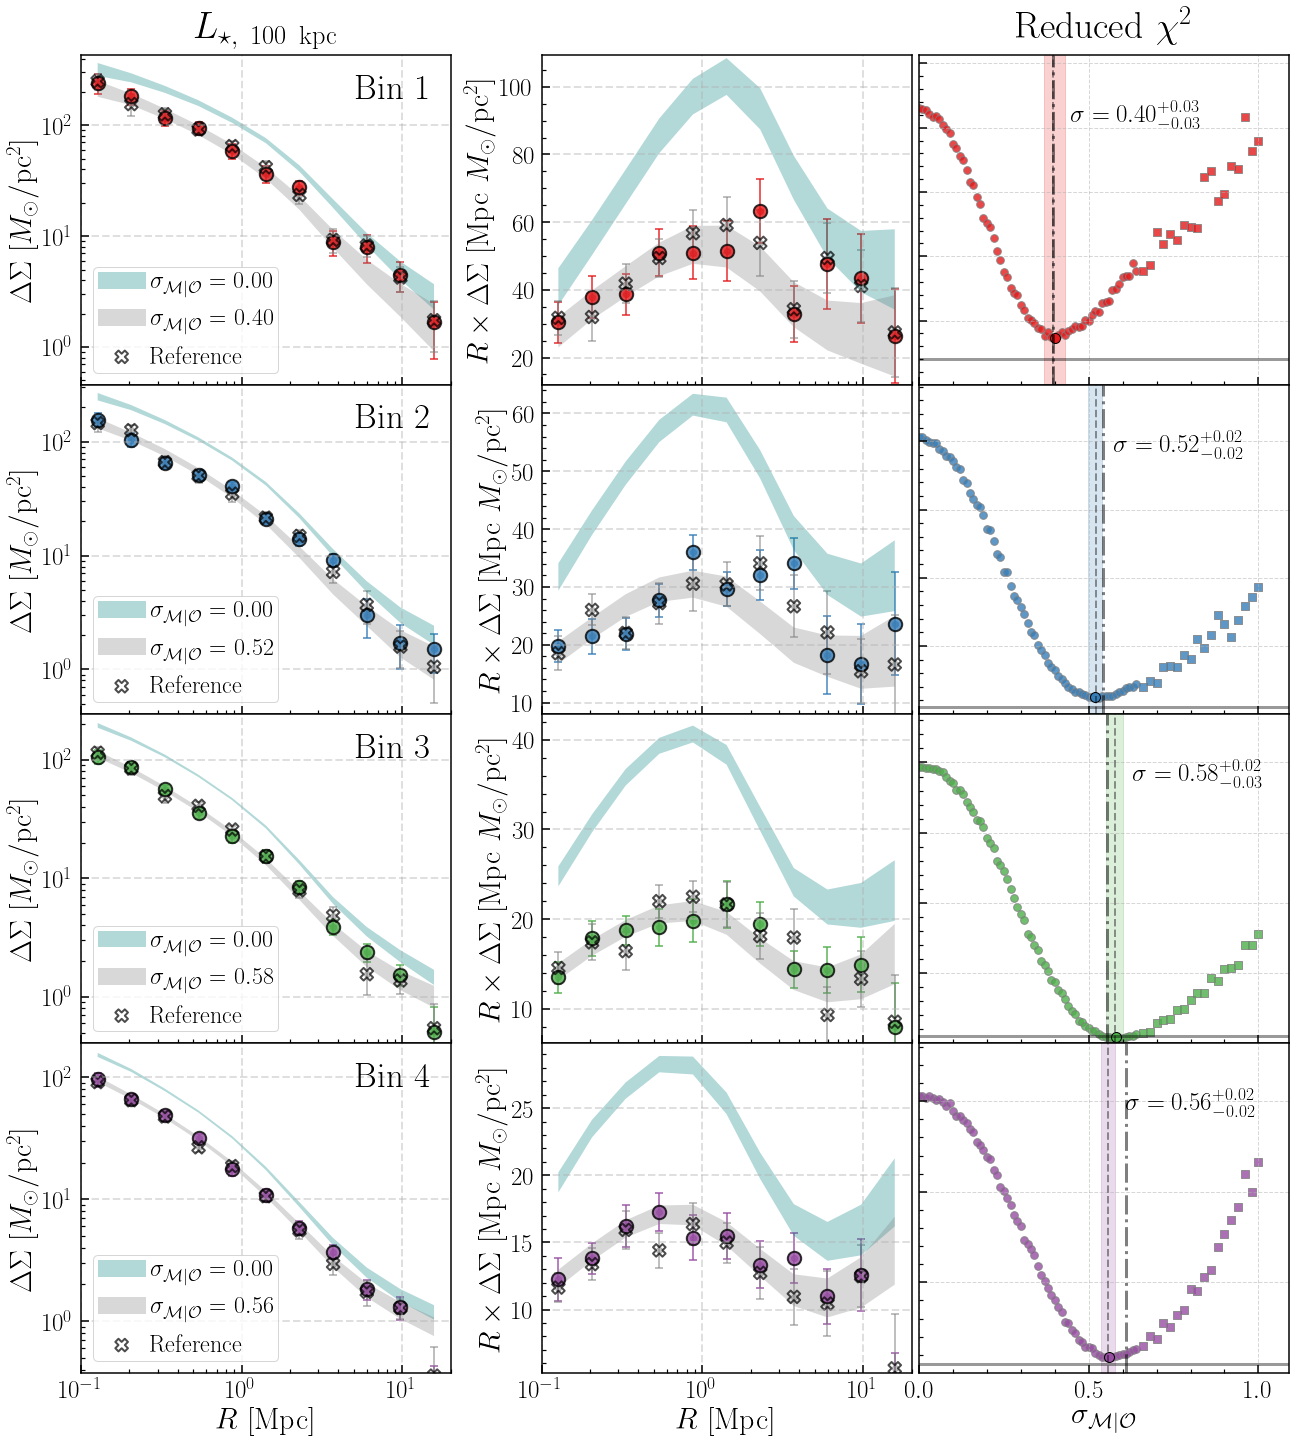

In [26]:
topn_m100 = wlensing.gather_topn_dsigma_profiles(
    hsc_use, s16a_rand, topn_bins, 'logm_100', n_rand=100000, n_boot=200, verbose=False, n_jk=40)

topn_l100 = wlensing.gather_topn_dsigma_profiles(
    hsc_use, s16a_rand, topn_bins, 'lum_100', n_rand=100000, n_boot=200, verbose=False, n_jk=40)

topn_m100_sum = scatter.compare_model_dsigma(
    topn_m100, sim_cat, model_err=True, poly=True, verbose=False)

topn_l100_sum = scatter.compare_model_dsigma(
    topn_l100, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_l100_sum, r'$L_{\star,\ 100\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m100_sum)

#### Outskirt luminosity between 50 to 100 kpc

In [31]:
lum_50_100 = np.log10(10.0 ** hsc_use['lum_100'] - 10.0 ** hsc_use['lum_50'])

hsc_use.add_column(Column(data=lum_50_100, name='lum_50_100'))

/var/folders/jh/02q43k0x5tggt_fghykc1pbw0000gn/T/ipykernel_50459/1129881292.py:1: RuntimeWarning: divide by zero encountered in log10
  lum_50_100 = np.log10(10.0 ** hsc_use['lum_100'] - 10.0 ** hsc_use['lum_50'])


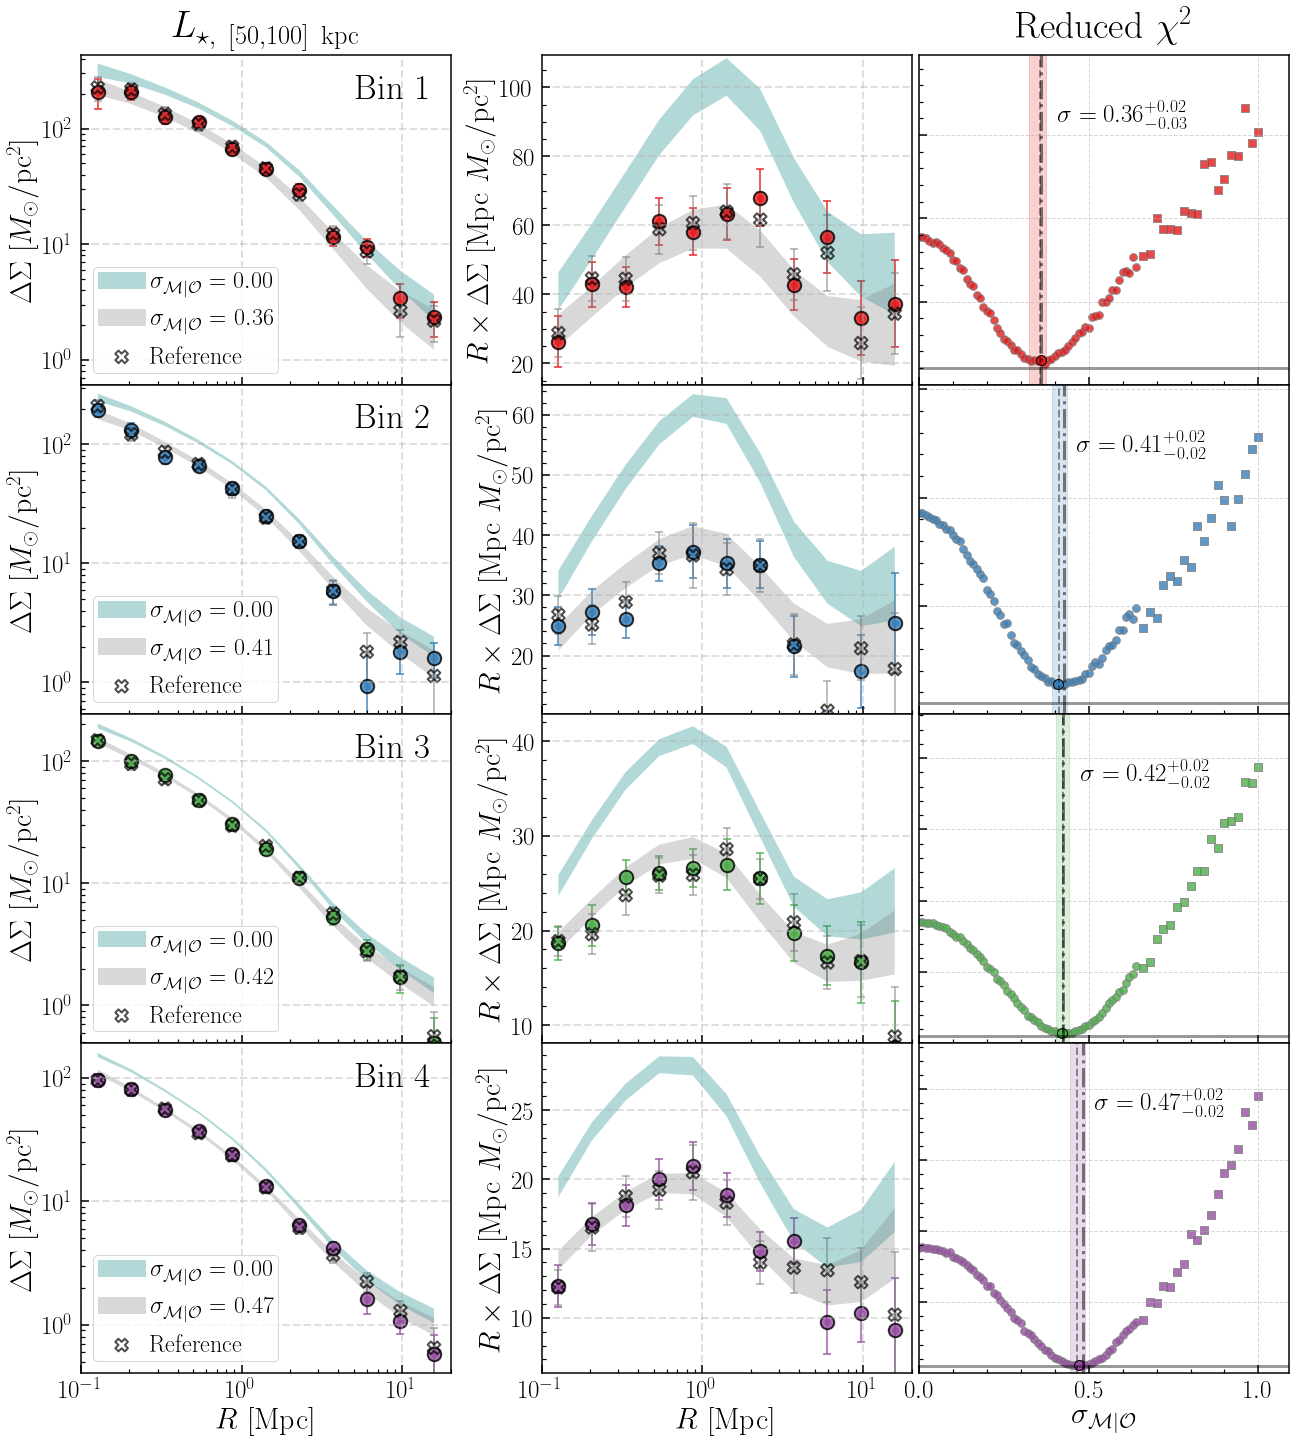

In [32]:
topn_m50_100 = wlensing.gather_topn_dsigma_profiles(
    hsc_use, s16a_rand, topn_bins, 'logm_50_100', n_rand=100000, n_boot=200, verbose=False, n_jk=40)

topn_l50_100 = wlensing.gather_topn_dsigma_profiles(
    hsc_use, s16a_rand, topn_bins, 'lum_50_100', n_rand=100000, n_boot=200, verbose=False, n_jk=40)

topn_m50_100_sum = scatter.compare_model_dsigma(
    topn_m50_100, sim_cat, model_err=True, poly=True, verbose=False)

topn_l50_100_sum = scatter.compare_model_dsigma(
    topn_l50_100, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_l50_100_sum, r'$L_{\star,\ [50,100]\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m50_100_sum)

#### Outskirt luminosity between 60 to 150 kpc

In [33]:
lum_60_150 = np.log10(10.0 ** hsc_use['lum_150'] - 10.0 ** hsc_use['lum_60'])

hsc_use.add_column(Column(data=lum_60_150, name='lum_60_150'))

/var/folders/jh/02q43k0x5tggt_fghykc1pbw0000gn/T/ipykernel_50459/3913017395.py:1: RuntimeWarning: divide by zero encountered in log10
  lum_60_150 = np.log10(10.0 ** hsc_use['lum_150'] - 10.0 ** hsc_use['lum_60'])


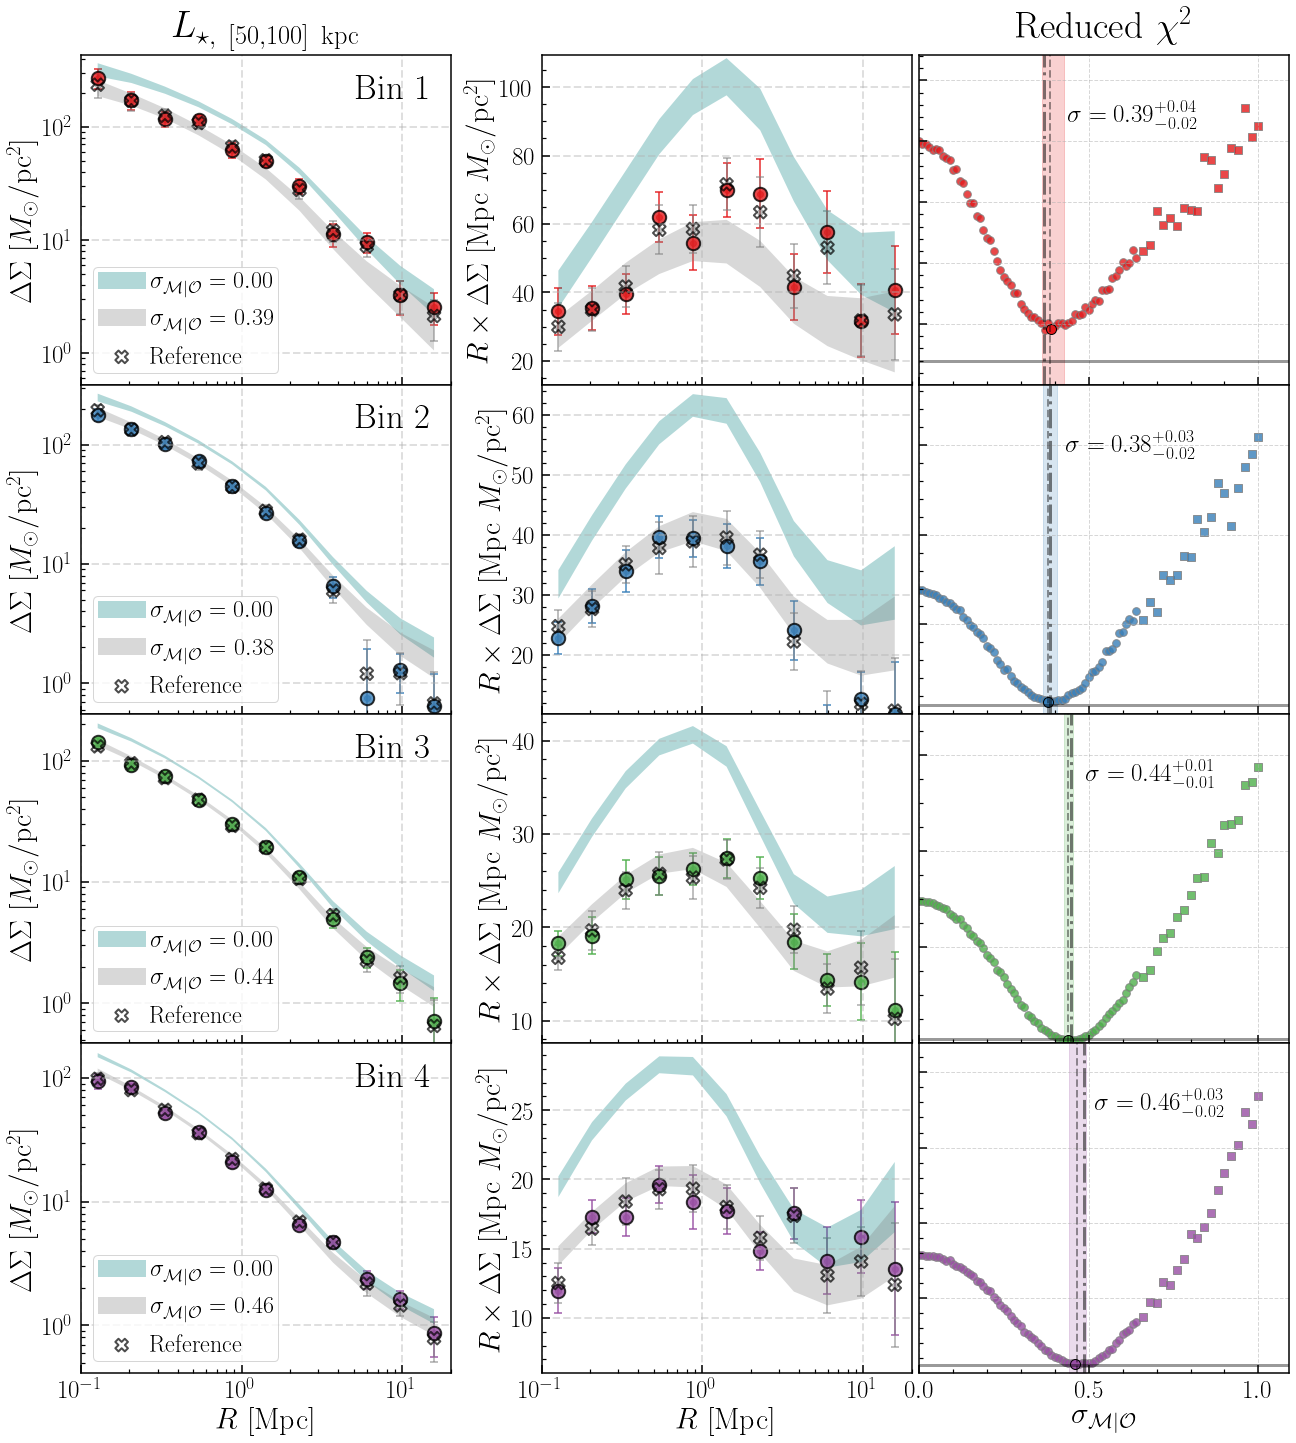

In [34]:
topn_m60_150 = wlensing.gather_topn_dsigma_profiles(
    hsc_use, s16a_rand, topn_bins, 'logm_60_150', n_rand=100000, n_boot=200, verbose=False, n_jk=40)

topn_l60_150 = wlensing.gather_topn_dsigma_profiles(
    hsc_use, s16a_rand, topn_bins, 'lum_60_150', n_rand=100000, n_boot=200, verbose=False, n_jk=40)

topn_m60_150_sum = scatter.compare_model_dsigma(
    topn_m60_150, sim_cat, model_err=True, poly=True, verbose=False)

topn_l60_150_sum = scatter.compare_model_dsigma(
    topn_l60_150, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_l60_150_sum, r'$L_{\star,\ [50,100]\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m60_150_sum)

## Profile Extrapolation

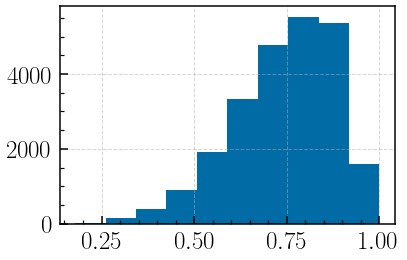

In [22]:
# Estimate the average axis ratio in the inner region 
# Here we use average axis ratio between 20 to 45 kpc
ba_avg = [profile.estimate_average_ba(
    gal, r_min=20, r_max=45, use_weight=True) for gal in hsc_use]

hsc_use.add_column(Column(data=ba_avg, name='ba_avg'))

_ = plt.hist(ba_avg)

In [268]:
def extrapolate_mass_sersic(gal, rmin=15.0, rmax=50.0, q_outskirt=0.9, debug=True):
    """Extrapolate the surface mass density profile using Sersic fit in the inner region.
    """
    # Area within each radius
    r_extra_inn = rmax * 0.9
    logr_extra = np.linspace(np.log10(r_extra_inn), 2.5, 120)
    rkpc_extra = 10.0 ** logr_extra
    area_extra = np.pi * rkpc_extra * (rkpc_extra * q_outskirt)

    # Radius mask
    rad_mask = (profile.RKPC_COMMON > rmin) & (profile.RKPC_COMMON <= rmax)

    # Mask for mass density profile
    sbp_mask = np.isfinite(gal['sbp']) & rad_mask & (gal['sbp'] > 0)

    # Fit Sersic profile to extrapolate the 1-D profile
    # Normalize the surface brightness profile
    val_norm = np.nanmedian(10.0 ** gal['sbp'])
    sbp_norm = (10.0 ** gal['sbp']) / val_norm

    # Initial parameter guesses; lower and upper limits
    ini = [2.5, np.nanmax(sbp_norm) * 0.9, gal['r50_100']]

    # Fit 1-Serisc profile
    try:
        best_sersic, _ = curve_fit(
            profile.Sersic, profile.RKPC_COMMON[sbp_mask], sbp_norm[sbp_mask], p0=ini, method='lm')

        ser_extra = profile.Sersic(
            rkpc_extra, best_sersic[0], best_sersic[1], best_sersic[2])
        sbp_extra = np.log10(ser_extra * val_norm)

        # Extra mass in the outskirt using mass density profiles
        mass_extra = np.cumsum(
            (10.0 ** sbp_extra)[1:] * (area_extra[1:] - area_extra[:-1]))

        mask = profile.RKPC_COMMON >= rmin
        logm_r_inn = interpolate.interp1d(
            np.log10(profile.RKPC_COMMON[mask]), gal['cog'][mask])(np.log10(r_extra_inn))

        cog_extra = np.log10(mass_extra + 10.0 ** logm_r_inn)
    except Exception:
        print("# Sersic fitting failed for %d" % gal['object_id'])
        sbp_extra, cog_extra = None, None
        if debug:
            print("# RA, Dec. : %9.5f %10.5f" % (gal['ra'], gal['dec']))
            print("# Redshift : %5.2f" % gal['z'])
            print("# R50 : %5.2f" % gal['r50_100'])
            print("# logM100      : %5.2f" % gal['logm_100'])
            print("# logM[50,100] : %5.2f" % gal['logm_50_100'])

    return rkpc_extra, sbp_extra, cog_extra, rad_mask


def get_extra_masses_sersic(gal, rmin=10, rmax=50., r_extra=[50.0, 100.0, 150.0], 
                            q_outskirt=0.8, verbose=False, debug=True):
    """
    Estimate extrapolated stellar mass using surface brightness profile and the
    curve of growth.
    """
    if isinstance(rmin, Iterable):
        for rr in rmin:
            rkpc_extra, sbp_extra, cog_extra, rad_mask = extrapolate_mass_sersic(
                gal, rmin=rr, rmax=rmax, q_outskirt=q_outskirt, debug=True)
            if sbp_extra is not None:
                break 
    else:
        rkpc_extra, sbp_extra, cog_extra, rad_mask = extrapolate_mass_sersic(
            gal, rmin=rmin, rmax=rmax, q_outskirt=q_outskirt, debug=True)

    if sbp_extra is not None:
        logm_extra_sbp = interpolate.interp1d(
            np.log10(rkpc_extra[1:]), cog_extra)(np.log10(r_extra))
    else:
        logm_extra_sbp = np.full(len(r_extra), np.nan)

    return rkpc_extra, sbp_extra, cog_extra, rad_mask, logm_extra_sbp

### Demonstrate the Extrapolation Process

- Just using one random galaxy

In [269]:
#gal = hsc_use[np.random.randint(0, high=(len(hsc_use) - 1))]
gal = hsc_use[hsc_use['object_id'] == 42287642406055972][0]

print("# RA, Dec. : %9.5f %10.5f" % (gal['ra'], gal['dec']))
print("# Redshift : %5.2f" % gal['z'])
print("# R50 : %5.2f" % gal['r50_100'])
print("# logM100      : %5.2f" % gal['logm_100'])
print("# logM[50,100] : %5.2f" % gal['logm_50_100'])

# RA, Dec. : 216.51621    0.50355
# Redshift :  0.33
# R50 :  4.55
# logM100      : 11.20
# logM[50,100] :  9.35


# Sersic fitting failed for 42287642406055972
# RA, Dec. : 216.51621    0.50355
# Redshift :  0.33
# R50 :  4.55
# logM100      : 11.20
# logM[50,100] :  9.35


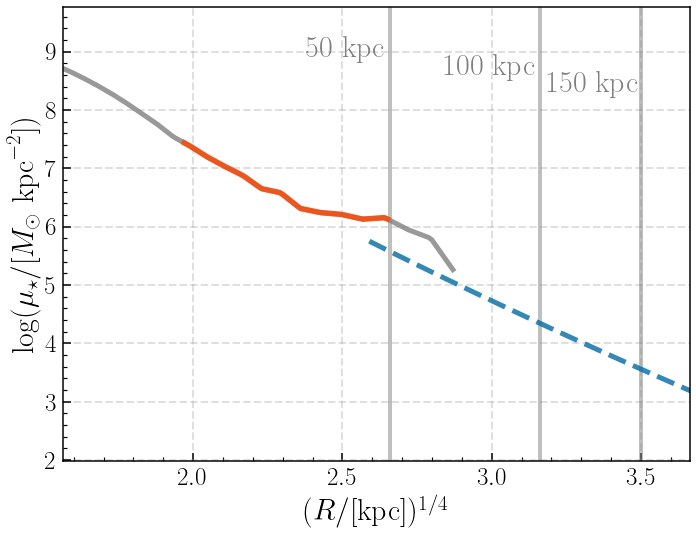

In [270]:
rkpc_extra, sbp_extra, cog_extra, rad_mask, logm_extra_sbp = get_extra_masses_sersic(
    gal, rmin=[10.0, 15.0, 20.0], rmax=50.0, q_outskirt=gal['ba_avg'])

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(left=0.12, right=0.99, bottom=0.15, top=0.99, wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.axvline(50.0 ** 0.25, linestyle='-', alpha=0.5, color='grey', linewidth=4)
ax1.text(32.0 ** 0.25, 8.9, r'$50\ \rm kpc$', fontsize=30, color='grey')
ax1.axvline(100.0 ** 0.25, linestyle='-', alpha=0.5, color='grey', linewidth=4)
ax1.text(65.0 ** 0.25, 8.6, r'$100\ \rm kpc$', fontsize=30, color='grey')
ax1.axvline(150.0 ** 0.25, linestyle='-', alpha=0.5, color='grey', linewidth=4)
ax1.text(103.0 ** 0.25, 8.3, r'$150\ \rm kpc$', fontsize=30, color='grey')

ax1.grid(linewidth=2.0, alpha=0.4, linestyle='--')

ax1.plot(r_kpc ** 0.25, gal['sbp'], linewidth=5.0, alpha=0.8, color='grey')

ax1.plot(r_kpc[rad_mask] ** 0.25, gal['sbp'][rad_mask], 
         linewidth=5.5, alpha=0.8, c='orangered')

if sbp_extra is not None:
    ax1.plot(rkpc_extra ** 0.25, sbp_extra, linewidth=5.0, linestyle='--', alpha=0.8)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

_ = ax1.set_xlim(6.0 ** 0.25, 180. ** 0.25)
_ = ax1.set_ylim(np.nanmin(sbp_extra), np.nanmax(gal['sbp']))

_ = ax1.set_xlabel('$(R/[\mathrm{kpc}])^{1/4}$', size=30)
_ = ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$', size=30)

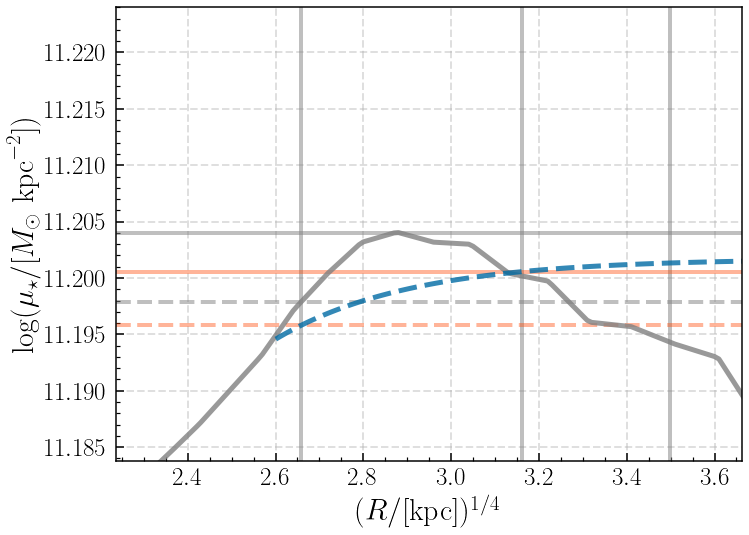

In [271]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(left=0.12, right=0.99, bottom=0.15, top=0.99, wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.grid(linewidth=2.0, alpha=0.4, linestyle='--')

ax1.axhline(gal['logm_50'], linestyle='--', alpha=0.5, color='grey', linewidth=4)
ax1.axhline(gal['logm_100'], linestyle='-', alpha=0.5, color='grey', linewidth=4)
ax1.axvline(50.0 ** 0.25, linestyle='-', alpha=0.5, color='grey', linewidth=4)
ax1.axvline(100.0 ** 0.25, linestyle='-', alpha=0.5, color='grey', linewidth=4)
ax1.axvline(150.0 ** 0.25, linestyle='-', alpha=0.5, color='grey', linewidth=4)

ax1.axhline(logm_extra_sbp[0], linestyle='--', alpha=0.4, color='orangered', linewidth=4)
ax1.axhline(logm_extra_sbp[1], linestyle='-', alpha=0.4, color='orangered', linewidth=4)

ax1.plot(r_kpc ** 0.25, gal['cog'], linewidth=5.0, alpha=0.8, color='grey')

ax1.plot(rkpc_extra[1:] ** 0.25, cog_extra, linewidth=5.0, linestyle='--', alpha=0.8)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

_ = ax1.set_xlim(25.0 ** 0.25, 180. ** 0.25)
_ = ax1.set_ylim(gal['logm_30'], np.nanmax(gal['cog']) + 0.02)

_ = ax1.set_xlabel('$(R/[\mathrm{kpc}])^{1/4}$', size=30)
_ = ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$', size=30)

In [273]:
logm_extra = []
rmin, rmax = [10., 12., 15., 20.], 50.
r_extra = [50., 75., 100., 150., 200., 300.,]

sample = hsc_use

for i in range(len(sample)):
    gal = sample[i]
    # Since TopN only cares about the ~2000 most massive cases.
    if gal['logm_100'] >= 11.20:
        ba_avg = gal['ba_avg']
        rkpc_extra, sbp_extra, cog_extra, rad_mask, logm_sbp = get_extra_masses_sersic(
            gal, rmin=rmin, rmax=rmax, r_extra=r_extra, q_outskirt=ba_avg)
    else:
        logm_sbp = np.full(len(r_extra), np.nan)
        
    logm_extra.append(logm_sbp)
    
    update_progress(i / len(sample))
    
logm_extra_arr = np.asarray(logm_extra)

Progress: [####################] 100.0%


In [277]:
logm_50_extra = np.asarray(logm_extra)[:, 0]
logm_75_extra = np.asarray(logm_extra)[:, 1]
logm_100_extra = np.asarray(logm_extra)[:, 2]
logm_150_extra = np.asarray(logm_extra)[:, 3]
logm_200_extra = np.asarray(logm_extra)[:, 4]
logm_300_extra = np.asarray(logm_extra)[:, 5]

#### [50, 100] kpc Outskirt Mass using Sersic Extrapolation

In [280]:
flag = (np.isfinite(logm_100_extra) & np.isfinite(logm_50_extra))

logm_50_100_ser = np.log10(10.0 ** logm_100_extra - 10.0 ** logm_50_extra)
print((~np.isfinite(logm_50_100_ser)).sum())

hsc_use.add_column(Column(data=logm_50_100_ser, name='logm_50_100_ser'))

hsc_good = hsc_use[flag]

211


/var/folders/jh/02q43k0x5tggt_fghykc1pbw0000gn/T/ipykernel_50459/345548068.py:3: RuntimeWarning: divide by zero encountered in log10
  logm_50_100_ser = np.log10(10.0 ** logm_100_extra - 10.0 ** logm_50_extra)


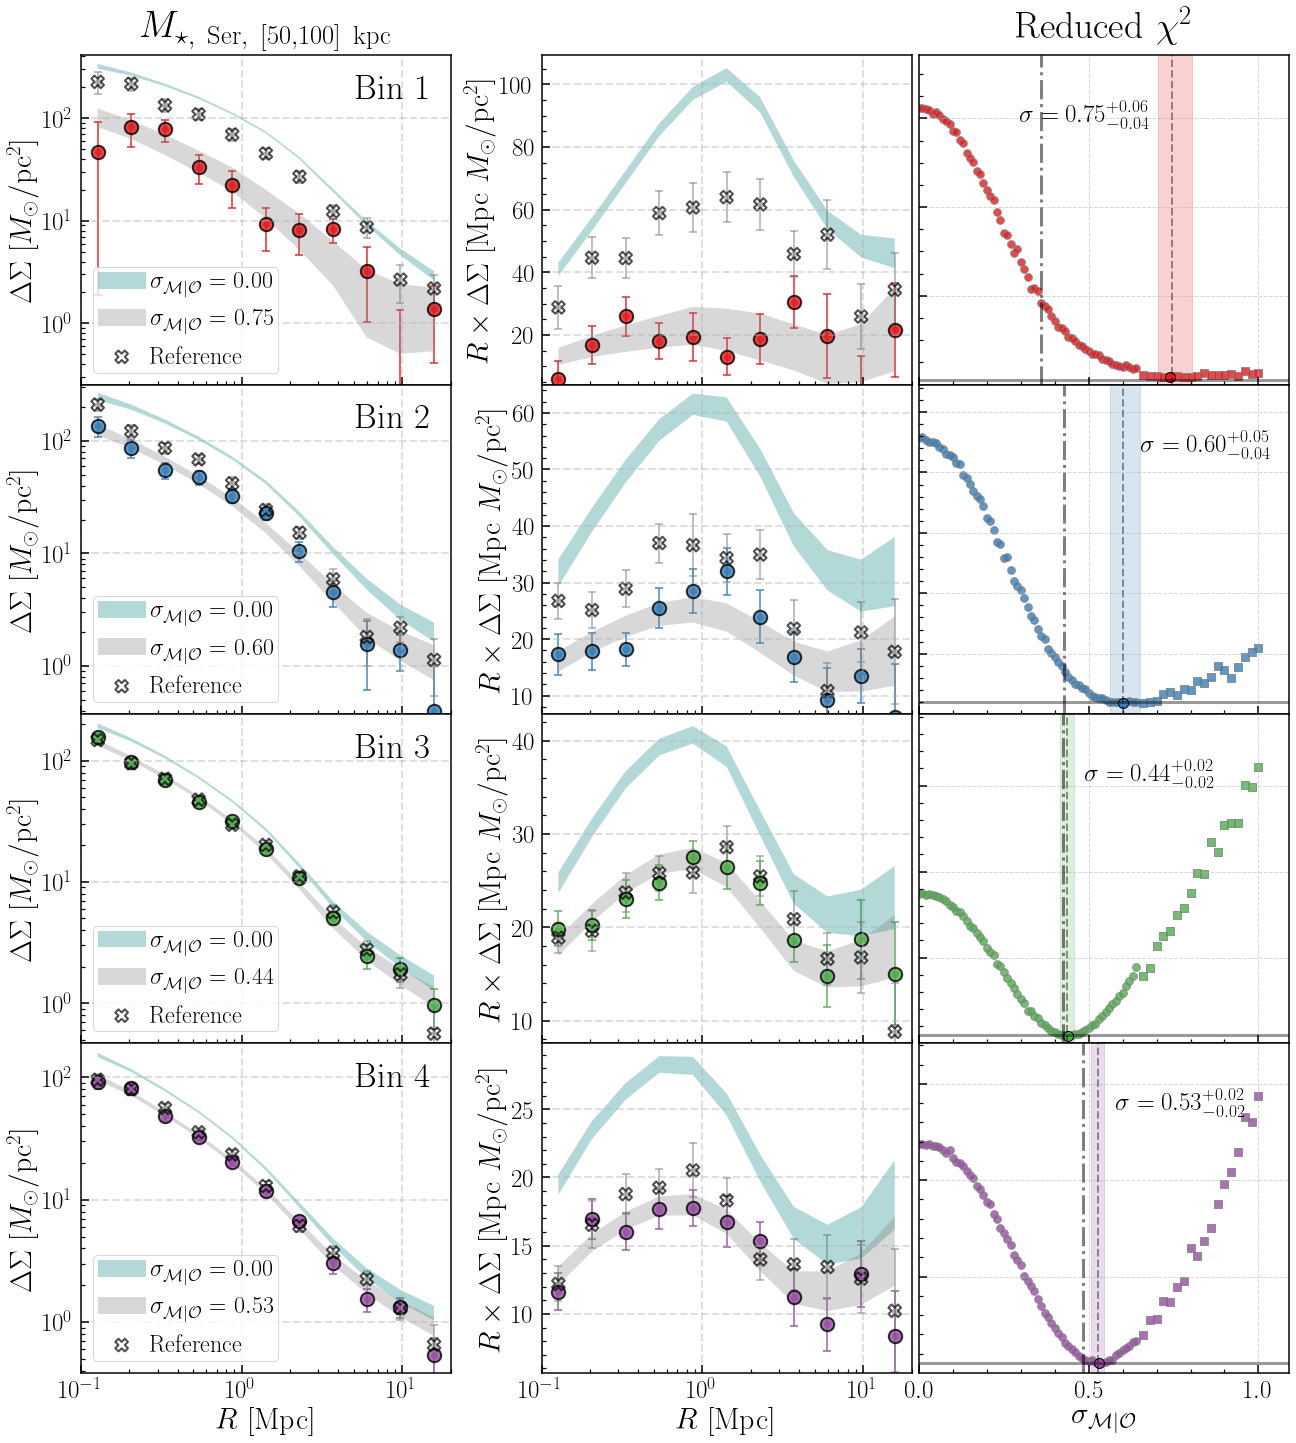

In [281]:
topn_m50_100_ser = wlensing.gather_topn_dsigma_profiles(
    hsc_good, s16a_rand, topn_bins, 'logm_50_100_ser', n_rand=200000, n_boot=200, verbose=False, n_jk=40)

topn_m50_100_ser_sum = scatter.compare_model_dsigma(
    topn_m50_100_ser, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_m50_100_ser_sum, r'$M_{\star,\ \rm Ser,\ [50,100]\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m50_100_sum)


##### Now remove the clearly problematic fitting results

(-0.1, 1.5)

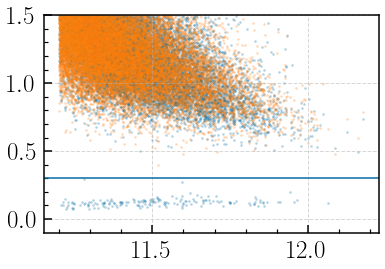

In [301]:
plt.scatter(hsc_use['logm_100'], logm_100_extra - logm_50_100_ser, s=3, alpha=0.2)
plt.scatter(hsc_use['logm_100'], hsc_use['logm_100'] - hsc_use['logm_50_100'], s=3, alpha=0.2)
#plt.axhline(11.6)
plt.axhline(0.3)

#plt.ylim(7.5, 12.9)
plt.ylim(-0.1, 1.5)

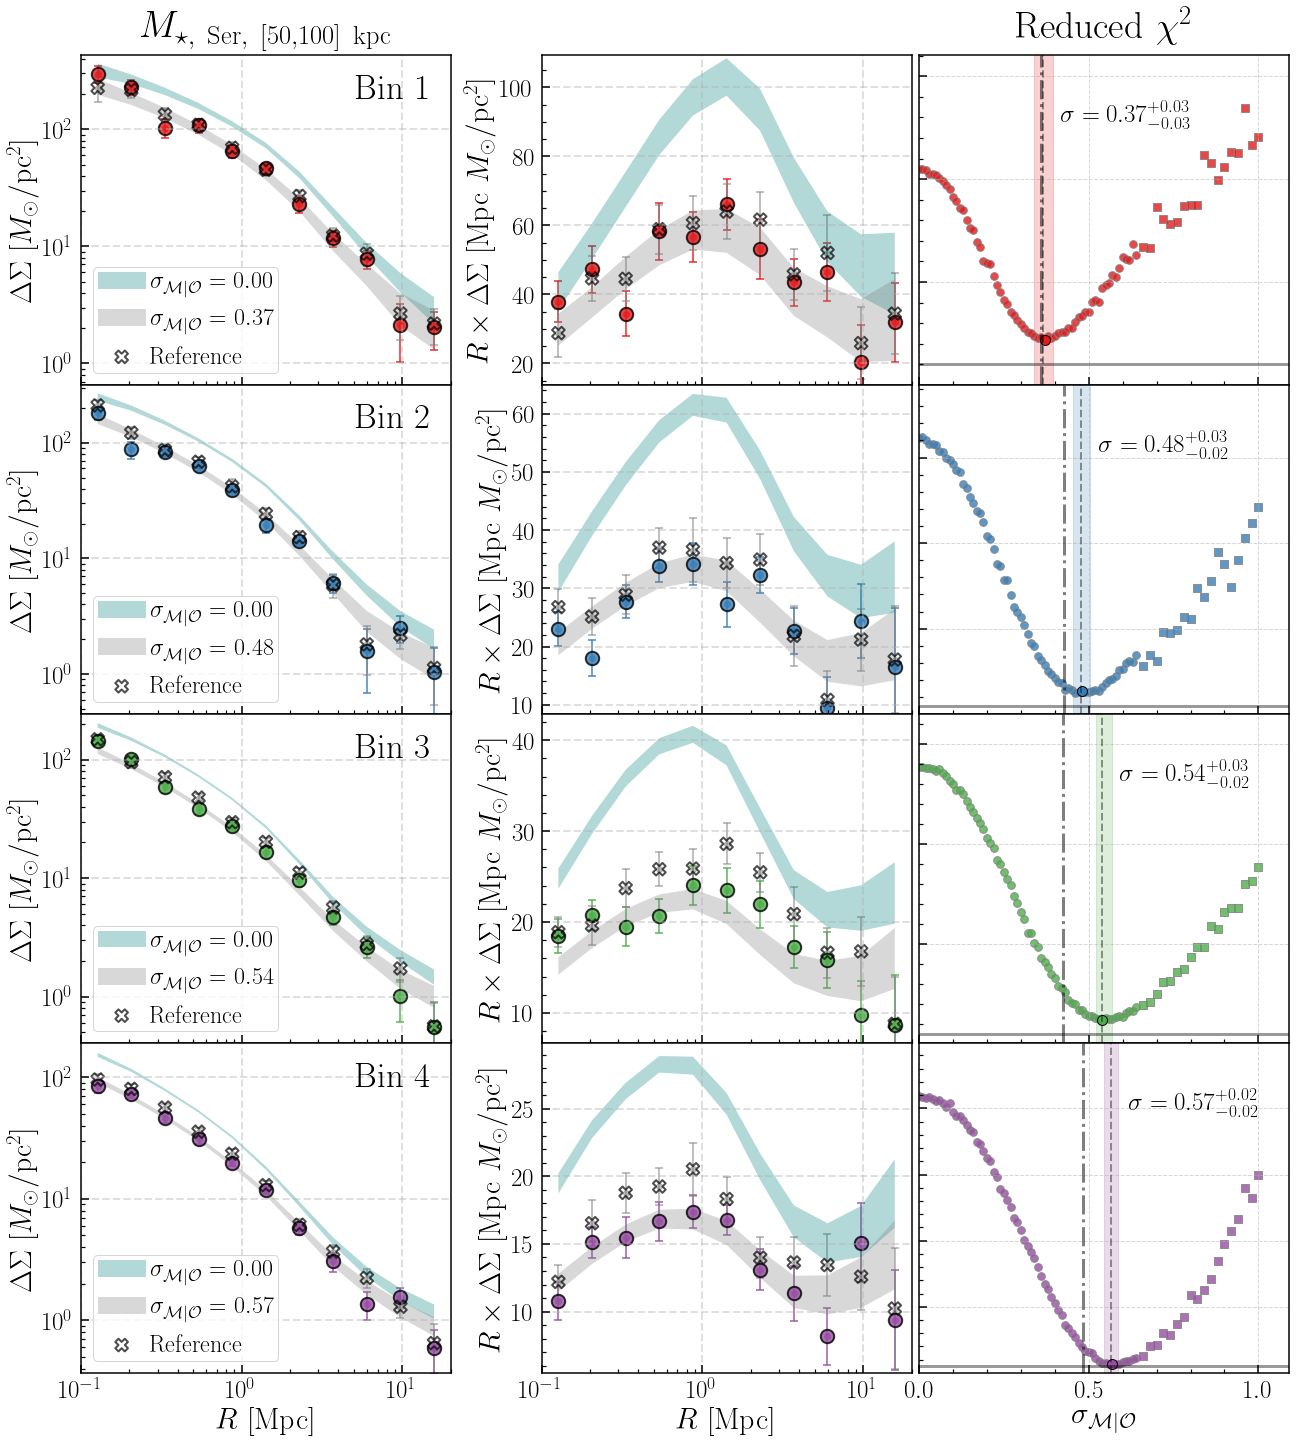

In [302]:
flag = (np.isfinite(logm_100_extra) & np.isfinite(logm_50_extra) & 
        (logm_100_extra - logm_50_100_ser > 0.3)) 

hsc_good = hsc_use[flag]

topn_m50_100_ser = wlensing.gather_topn_dsigma_profiles(
    hsc_good, s16a_rand, topn_bins, 'logm_50_100_ser', n_rand=200000, n_boot=200, verbose=False, n_jk=40)

topn_m50_100_ser_sum = scatter.compare_model_dsigma(
    topn_m50_100_ser, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_m50_100_ser_sum, r'$M_{\star,\ \rm Ser,\ [50,100]\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m50_100_sum)

#### 100 kpc Aperture Mass using Sersic Extrapolation 

In [282]:
logm_100_ser = logm_100_extra

hsc_use.add_column(Column(data=logm_100_ser, name='logm_100_ser'))

In [303]:
flag = (np.isfinite(logm_100_extra) & np.isfinite(logm_150_extra) & (logm_100_extra - logm_50_100_ser > 0.3))

hsc_good = hsc_use[flag]

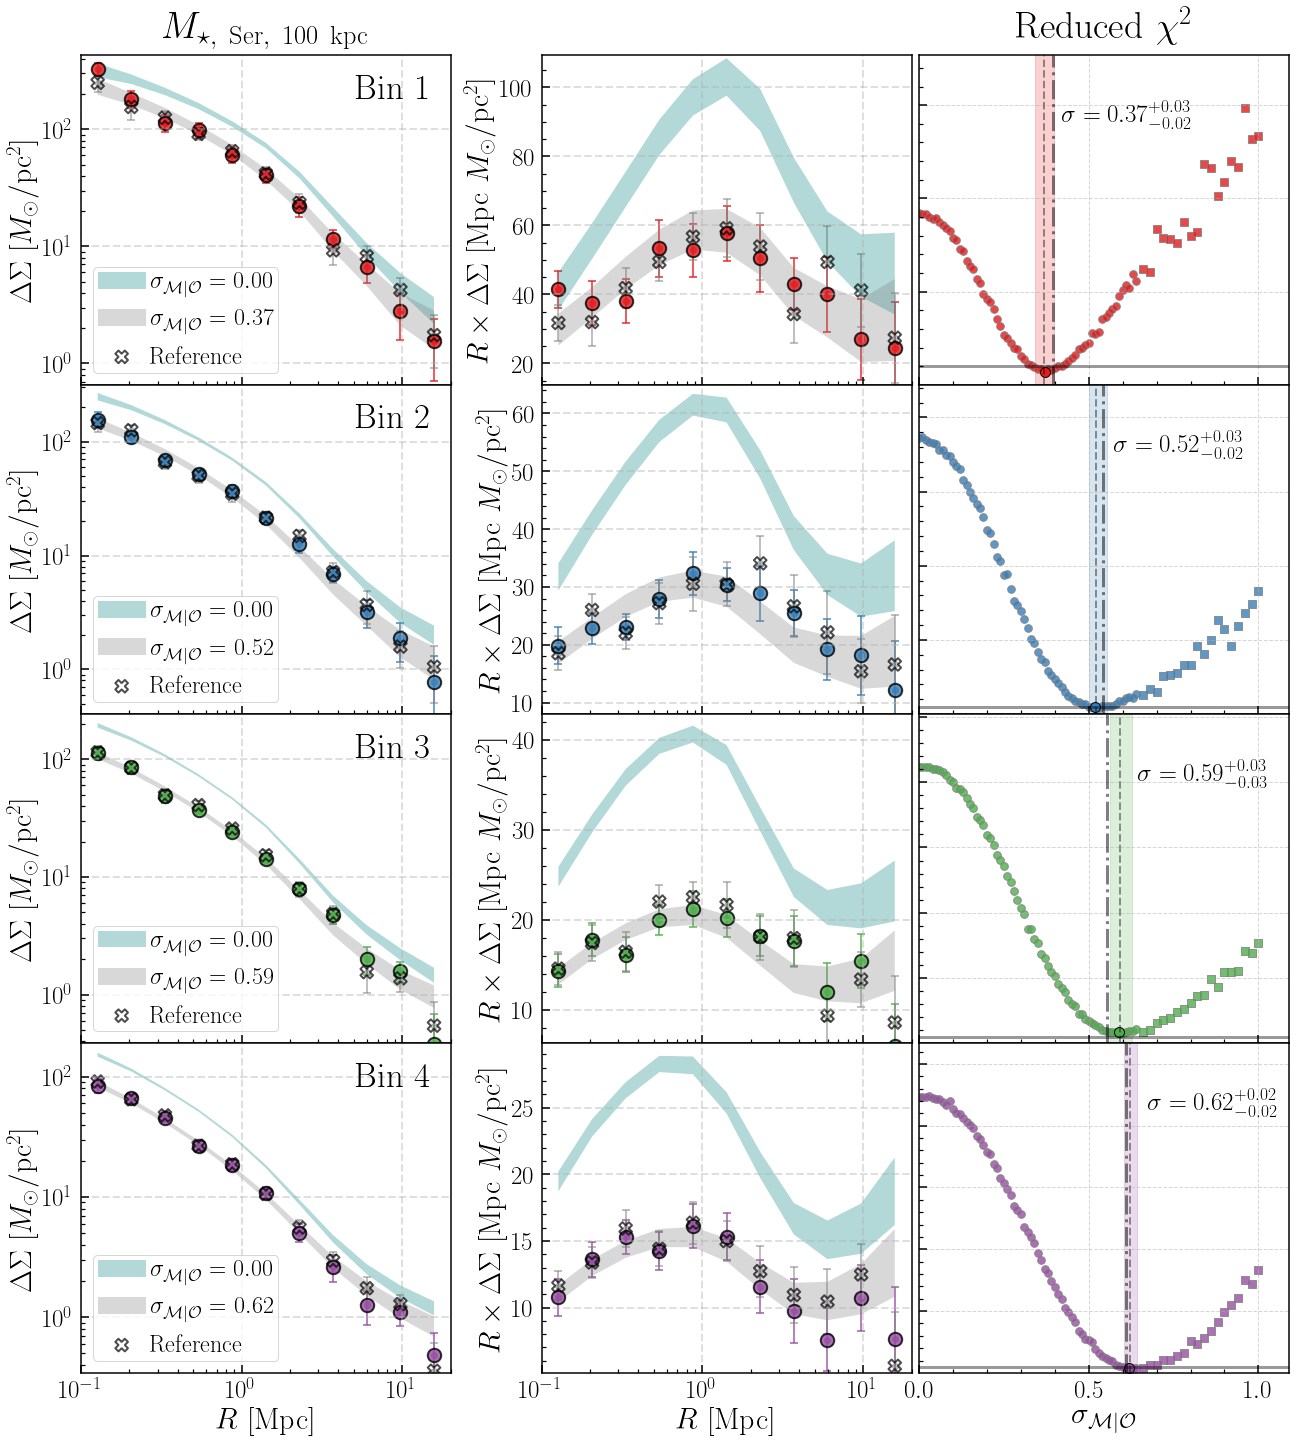

In [304]:
topn_m100_ser = wlensing.gather_topn_dsigma_profiles(
    hsc_good, s16a_rand, topn_bins, 'logm_100_ser', n_rand=200000, n_boot=200, verbose=False, n_jk=40)

topn_m100_ser_sum = scatter.compare_model_dsigma(
    topn_m100_ser, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_m100_ser_sum, r'$M_{\star,\ \rm Ser,\ 100\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m100_sum)

#### 200 kpc aperture stellar mass

In [305]:
hsc_use.add_column(Column(data=logm_200_extra, name='logm_200_ser'))

flag = (np.isfinite(logm_200_extra) & np.isfinite(logm_100_extra) & (logm_100_extra - logm_50_100_ser > 0.3))

hsc_good = hsc_use[flag]

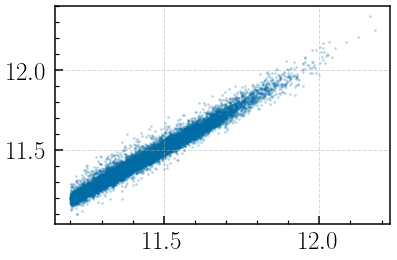

In [308]:
# After excluding the problematic ones, the relation looks normal
plt.scatter(hsc_use['logm_100'][flag], logm_200_extra[flag], s=3, alpha=0.2)

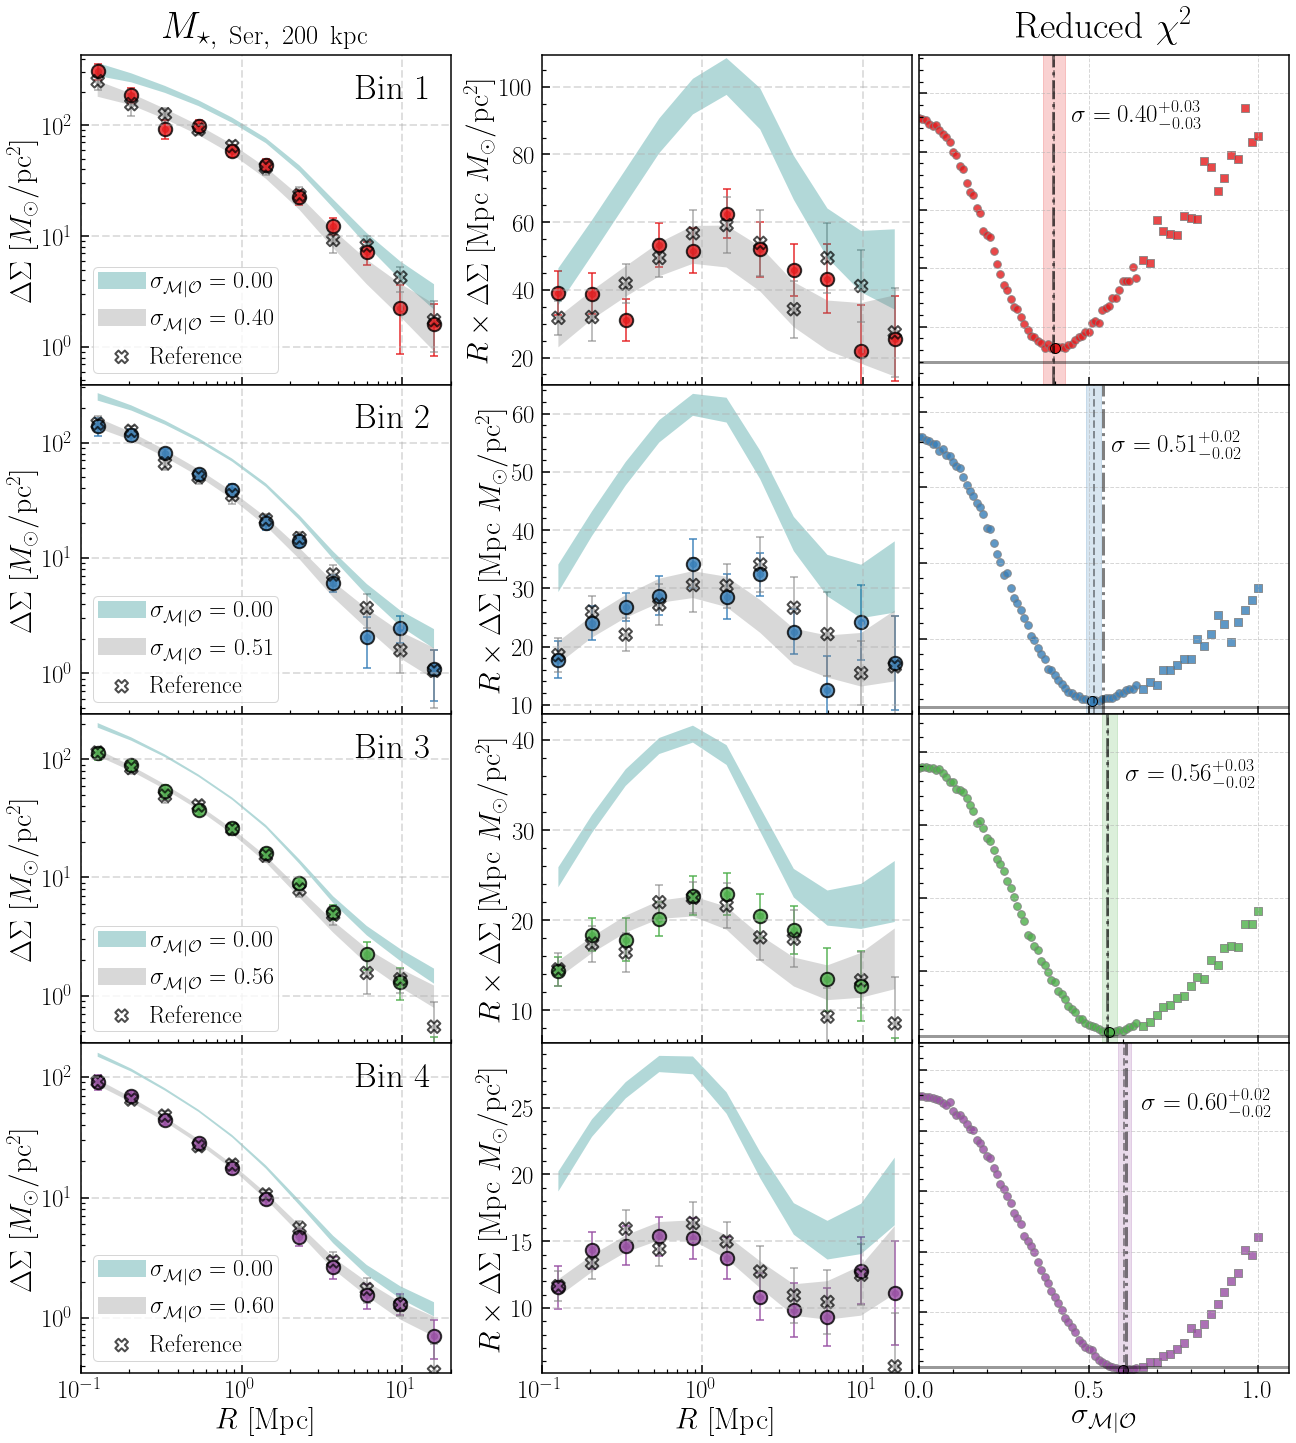

In [306]:
topn_m200_ser = wlensing.gather_topn_dsigma_profiles(
    hsc_good, s16a_rand, topn_bins, 'logm_200_ser', n_rand=200000, n_boot=200, verbose=False, n_jk=40)

topn_m200_ser_sum = scatter.compare_model_dsigma(
    topn_m200_ser, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_m200_ser_sum, r'$M_{\star,\ \rm Ser,\ 200\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m100_sum)

#### Outskirt mass between 50 and 200 kpc using Sersic extrapolation

In [314]:
logm_50_200_ser = np.log10(10.0 ** logm_200_extra - 10.0 ** logm_50_extra)

hsc_use.add_column(Column(data=logm_50_200_ser, name='logm_50_200_ser'))

/var/folders/jh/02q43k0x5tggt_fghykc1pbw0000gn/T/ipykernel_50459/2135723336.py:1: RuntimeWarning: divide by zero encountered in log10
  logm_50_200_ser = np.log10(10.0 ** logm_200_extra - 10.0 ** logm_50_extra)


In [315]:
flag = (np.isfinite(logm_200_extra) & np.isfinite(logm_100_extra) & np.isfinite(logm_50_extra) & 
        (logm_100_extra - logm_50_100_ser > 0.3))

hsc_good = hsc_use[flag]

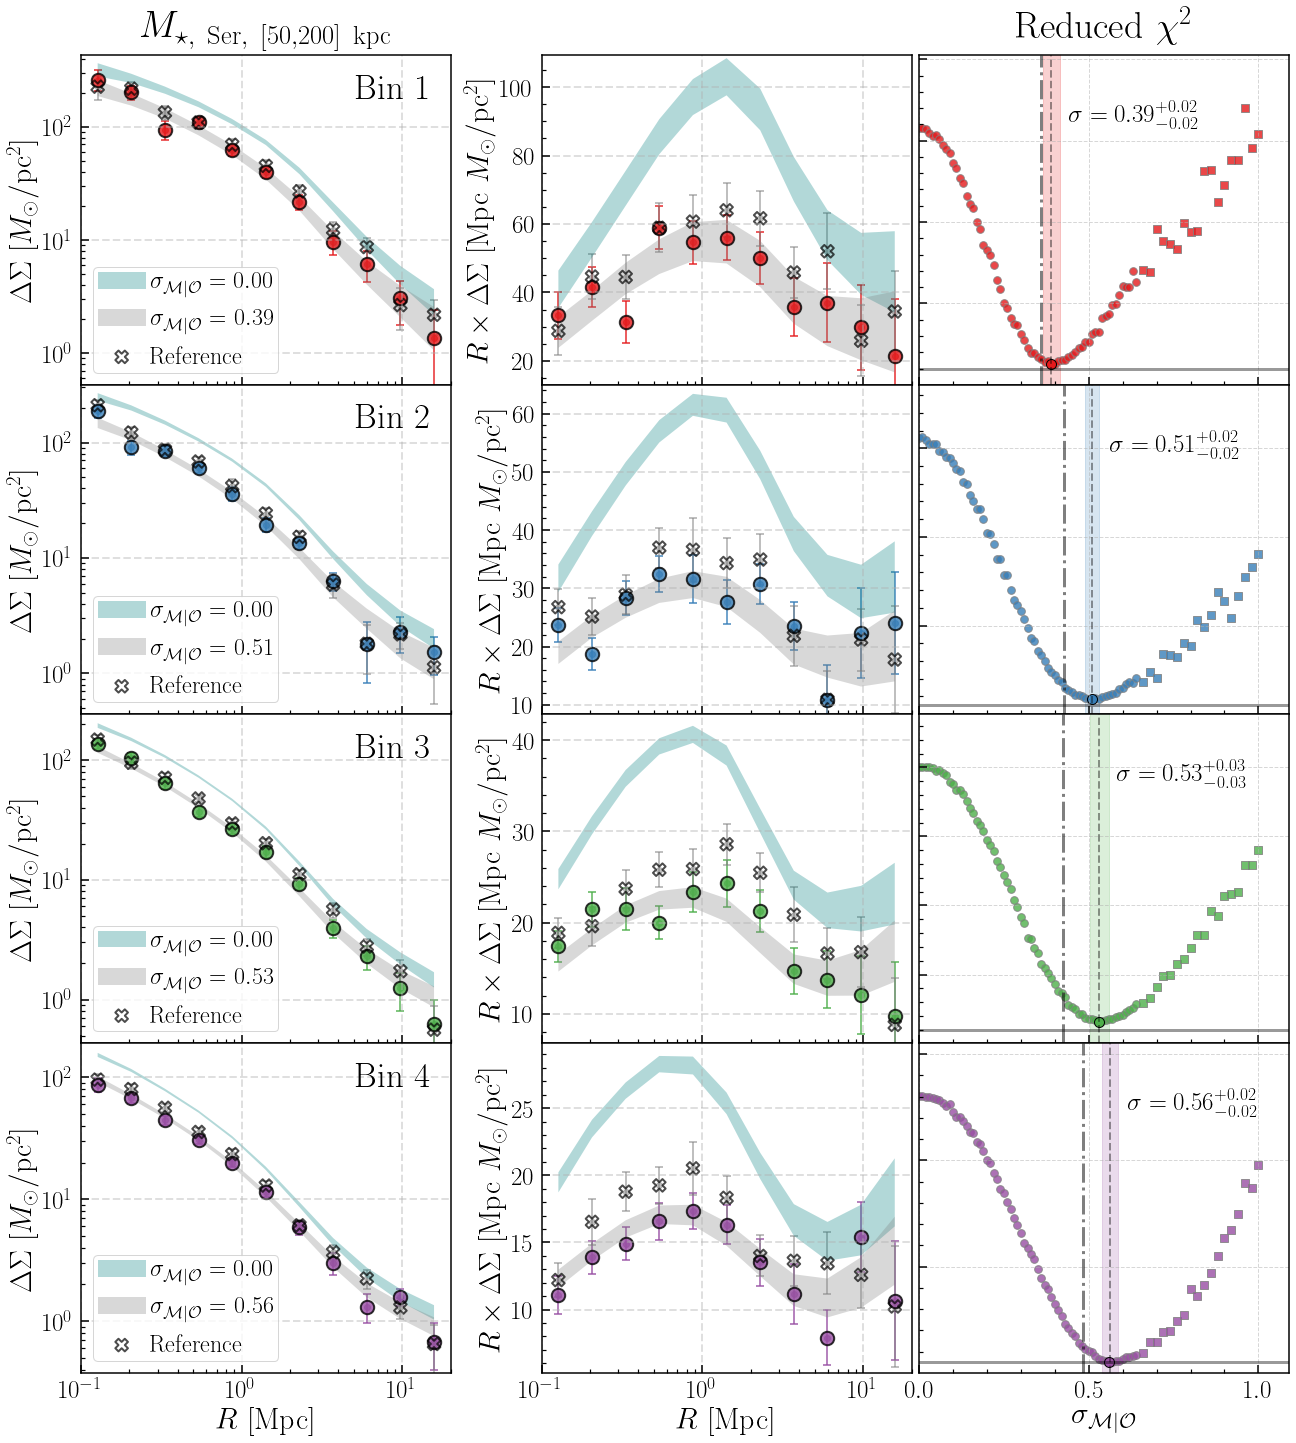

In [316]:
topn_m50_200_ser = wlensing.gather_topn_dsigma_profiles(
    hsc_good, s16a_rand, topn_bins, 'logm_50_200_ser', n_rand=200000, n_boot=200, verbose=False, n_jk=40)

topn_m50_200_ser_sum = scatter.compare_model_dsigma(
    topn_m50_200_ser, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_m50_200_ser_sum, r'$M_{\star,\ \rm Ser,\ [50,200]\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m50_100_sum)

### Extrapolate to large radius using the profile between 10 to 75 kpc

In [319]:
logm_extra_2 = []
rmin_2, rmax_2 = [10., 12., 15., 20.], 75.
r_extra_2 = [100., 150., 200., 300.,]

for i in range(len(sample)):
    gal = sample[i]
    if gal['logm_100'] >= 11.20:
        ba_avg = gal['ba_avg']
        rkpc_extra, sbp_extra, cog_extra, rad_mask, logm_sbp = get_extra_masses_sersic(
            gal, rmin=rmin_2, rmax=rmax_2, r_extra=r_extra_2, q_outskirt=ba_avg)
    else:
        logm_sbp = np.full(len(r_extra_2), np.nan)
        
    logm_extra_2.append(logm_sbp)
    
    update_progress(i / len(sample))
    
logm_extra_arr_2 = np.asarray(logm_extra_2)

Progress: [####################] 100.0%


In [320]:
logm_100_extra_2 = np.asarray(logm_extra_2)[:, 0]
logm_150_extra_2 = np.asarray(logm_extra_2)[:, 1]
logm_200_extra_2 = np.asarray(logm_extra_2)[:, 2]
logm_300_extra_2 = np.asarray(logm_extra_2)[:, 3]

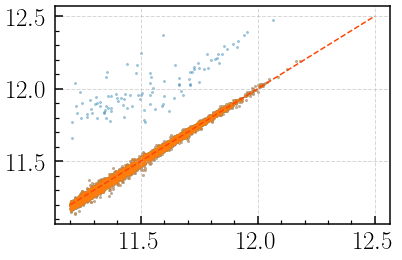

In [329]:
# Remove the failed fitting
plt.plot([11.2, 12.5], [11.2, 12.5], linestyle='--', color='orangered')
plt.scatter(hsc_use['logm_100'], logm_100_extra_2, s=4, alpha=0.3)

flag = (logm_100_extra_2 - hsc_use['logm_100'] <= 0.2)
plt.scatter(hsc_use['logm_100'][flag], logm_100_extra_2[flag], s=4, alpha=0.3)


In [331]:
hsc_use.add_column(Column(data=logm_200_extra_2, name='logm_200_extra_2'))
hsc_use.add_column(Column(data=logm_300_extra_2, name='logm_300_extra_2'))

hsc_good = hsc_use[flag]

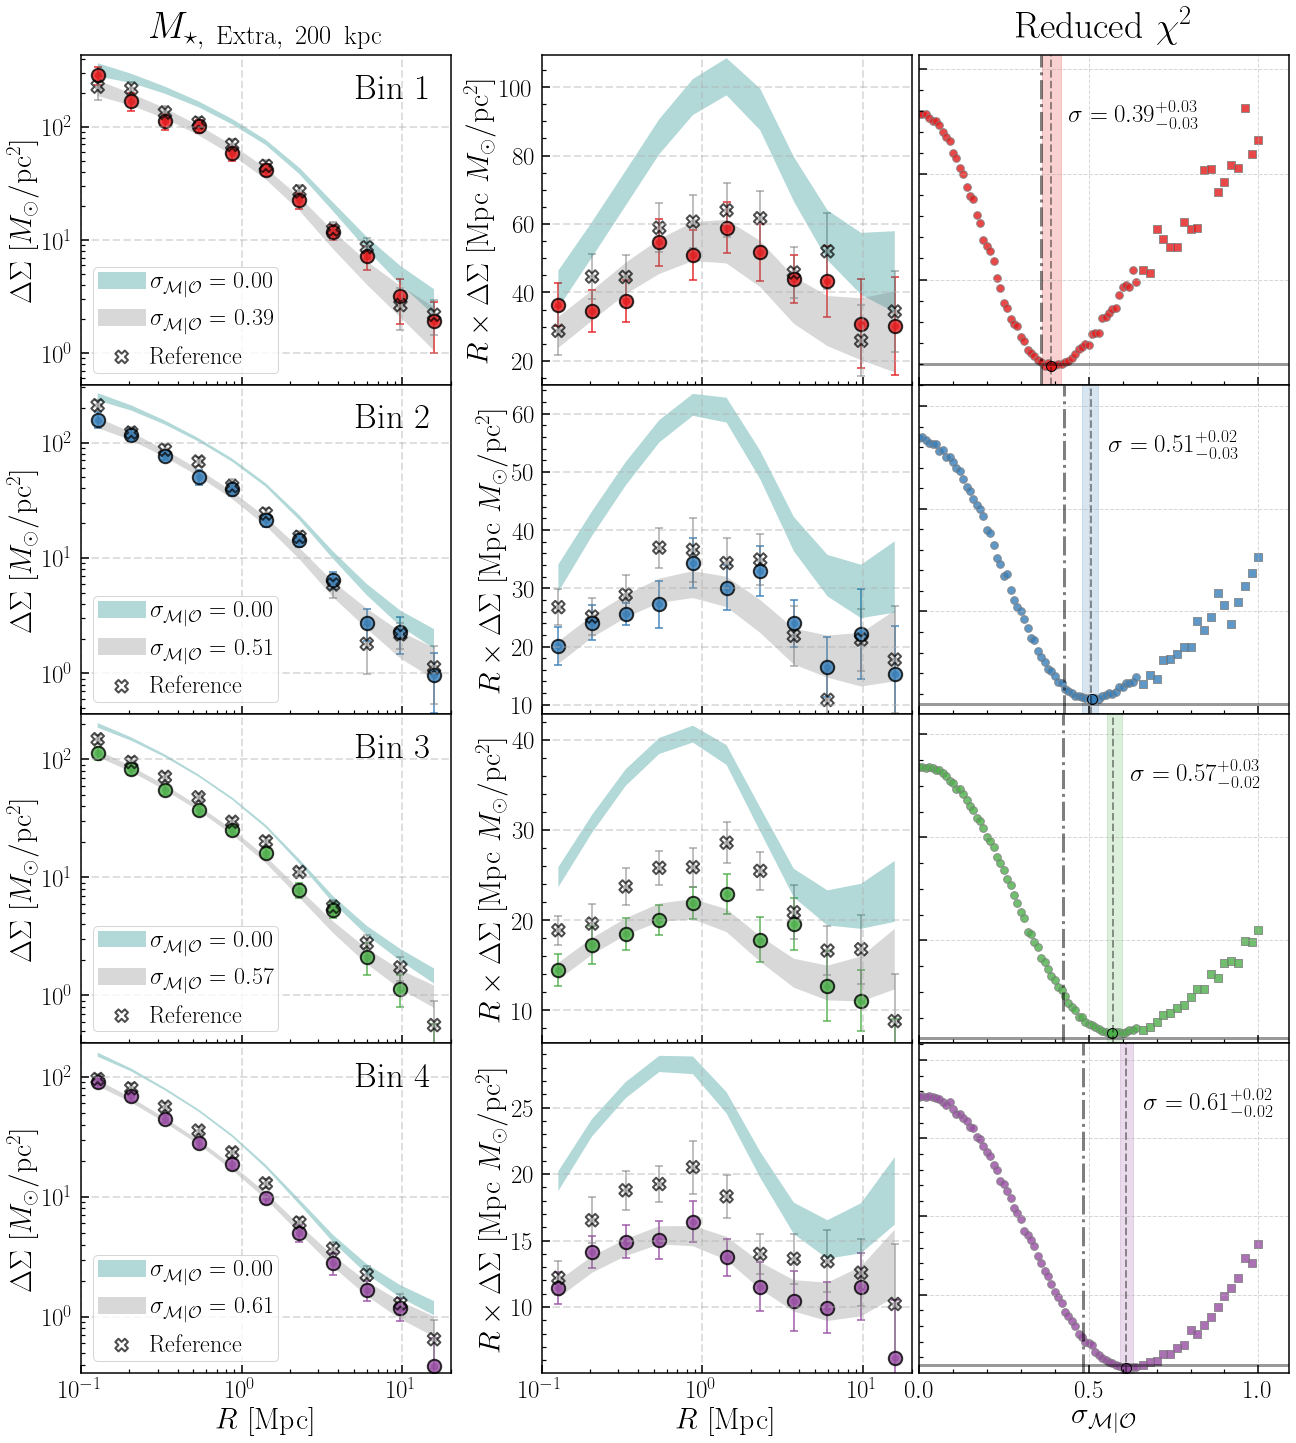

In [333]:
topn_m200_extra = wlensing.gather_topn_dsigma_profiles(
    hsc_good, s16a_rand, topn_bins, 'logm_200_extra_2', n_rand=200000, n_boot=200, verbose=False, n_jk=40)

topn_m200_extra_sum = scatter.compare_model_dsigma(
    topn_m200_extra, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_m200_extra_sum, r'$M_{\star,\ \rm Extra,\ 200\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m50_100_sum)

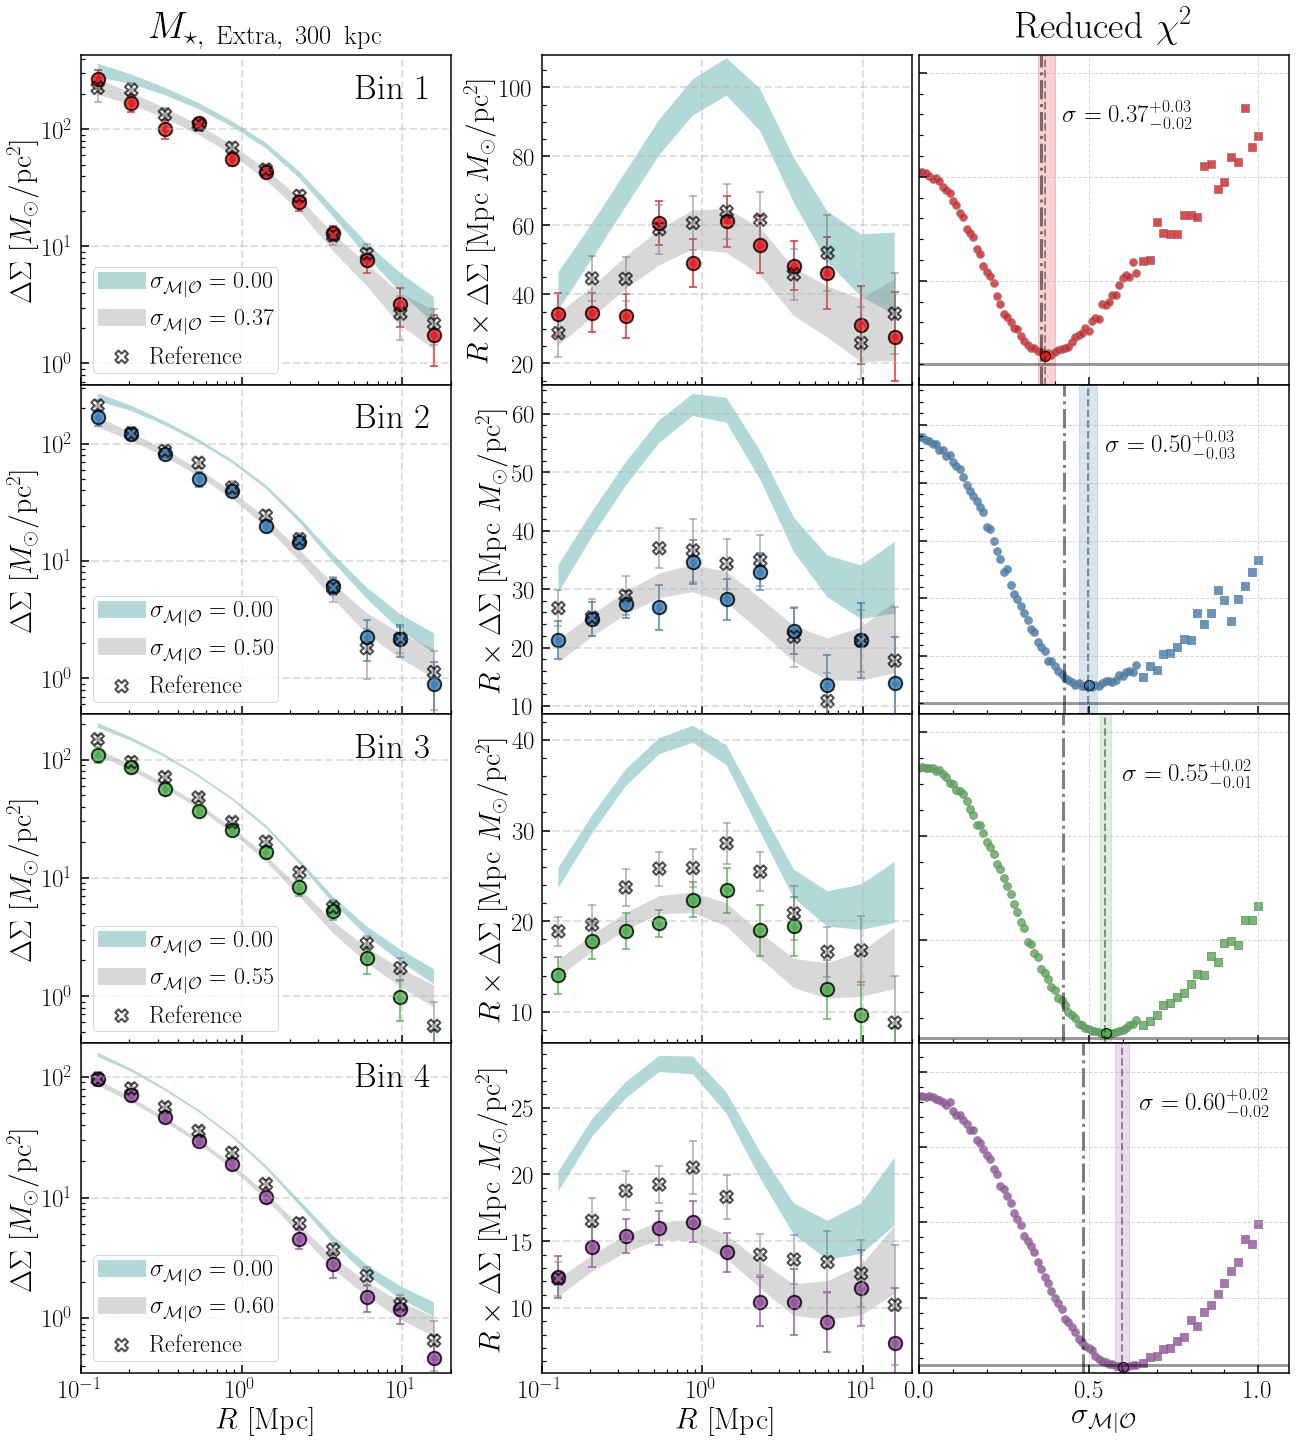

In [335]:
topn_m300_extra = wlensing.gather_topn_dsigma_profiles(
    hsc_good, s16a_rand, topn_bins, 'logm_300_extra_2', n_rand=200000, n_boot=300, verbose=False, n_jk=40)

topn_m300_extra_sum = scatter.compare_model_dsigma(
    topn_m300_extra, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_m300_extra_sum, r'$M_{\star,\ \rm Extra,\ 300\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m50_100_sum)

#### Aperture mass using the extrapolated profiles

In [339]:
hsc_use.remove_column('logm_50_200_extra')
hsc_use.remove_column('logm_50_300_extra')

In [340]:
logm_50_200_extra = np.log10(10.0 ** logm_200_extra_2 - 10.0 ** hsc_use['logm_50'])
logm_50_300_extra = np.log10(10.0 ** logm_300_extra_2 - 10.0 ** hsc_use['logm_50'])

hsc_use.add_column(Column(data=logm_50_200_extra, name='logm_50_200_extra'))
hsc_use.add_column(Column(data=logm_50_300_extra, name='logm_50_300_extra'))

flag = ((logm_100_extra_2 - hsc_use['logm_100'] <= 0.2) & np.isfinite(logm_50_200_extra) & 
        np.isfinite(logm_50_300_extra))

hsc_good = hsc_use[flag]

/var/folders/jh/02q43k0x5tggt_fghykc1pbw0000gn/T/ipykernel_50459/2701395717.py:1: RuntimeWarning: invalid value encountered in log10
  logm_50_200_extra = np.log10(10.0 ** logm_200_extra_2 - 10.0 ** hsc_use['logm_50'])
/var/folders/jh/02q43k0x5tggt_fghykc1pbw0000gn/T/ipykernel_50459/2701395717.py:2: RuntimeWarning: invalid value encountered in log10
  logm_50_300_extra = np.log10(10.0 ** logm_300_extra_2 - 10.0 ** hsc_use['logm_50'])


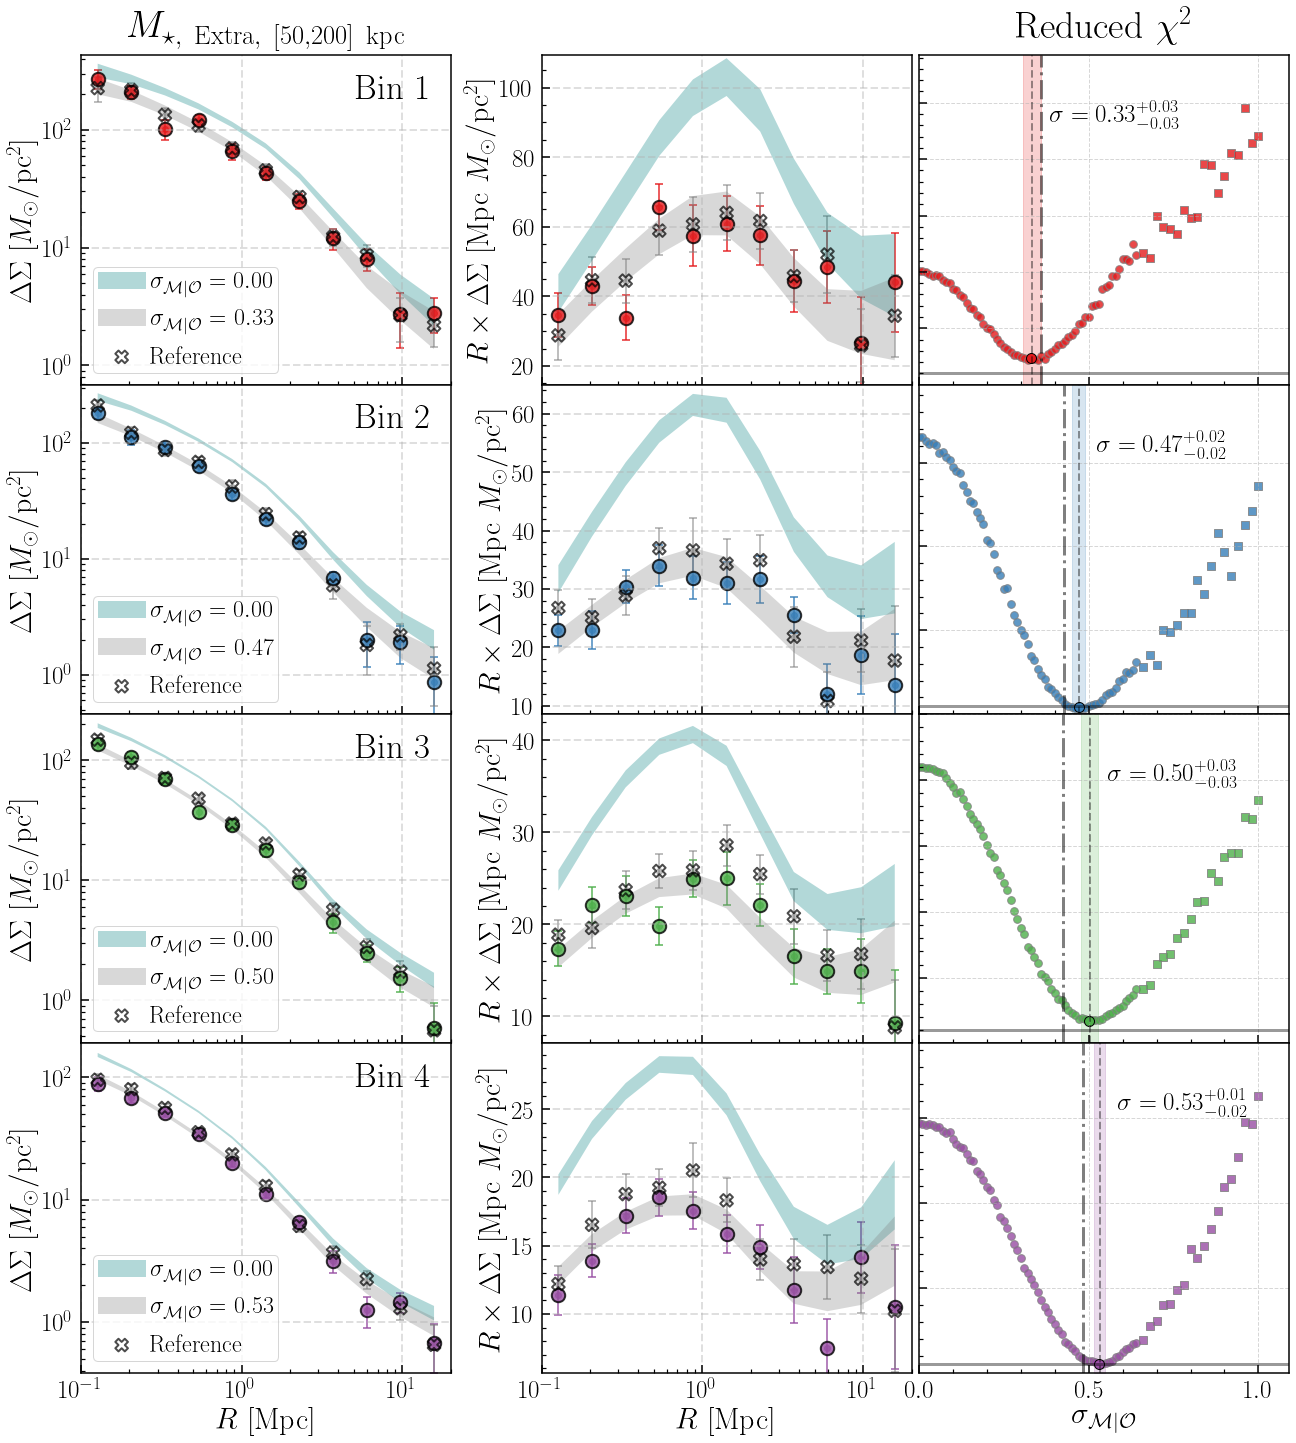

In [341]:
topn_m50_200_extra = wlensing.gather_topn_dsigma_profiles(
    hsc_good, s16a_rand, topn_bins, 'logm_50_200_extra', n_rand=200000, n_boot=200, verbose=False, n_jk=40)

topn_m50_200_extra_sum = scatter.compare_model_dsigma(
    topn_m50_200_extra, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_m50_200_extra_sum, r'$M_{\star,\ \rm Extra,\ [50, 200]\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m50_100_sum)

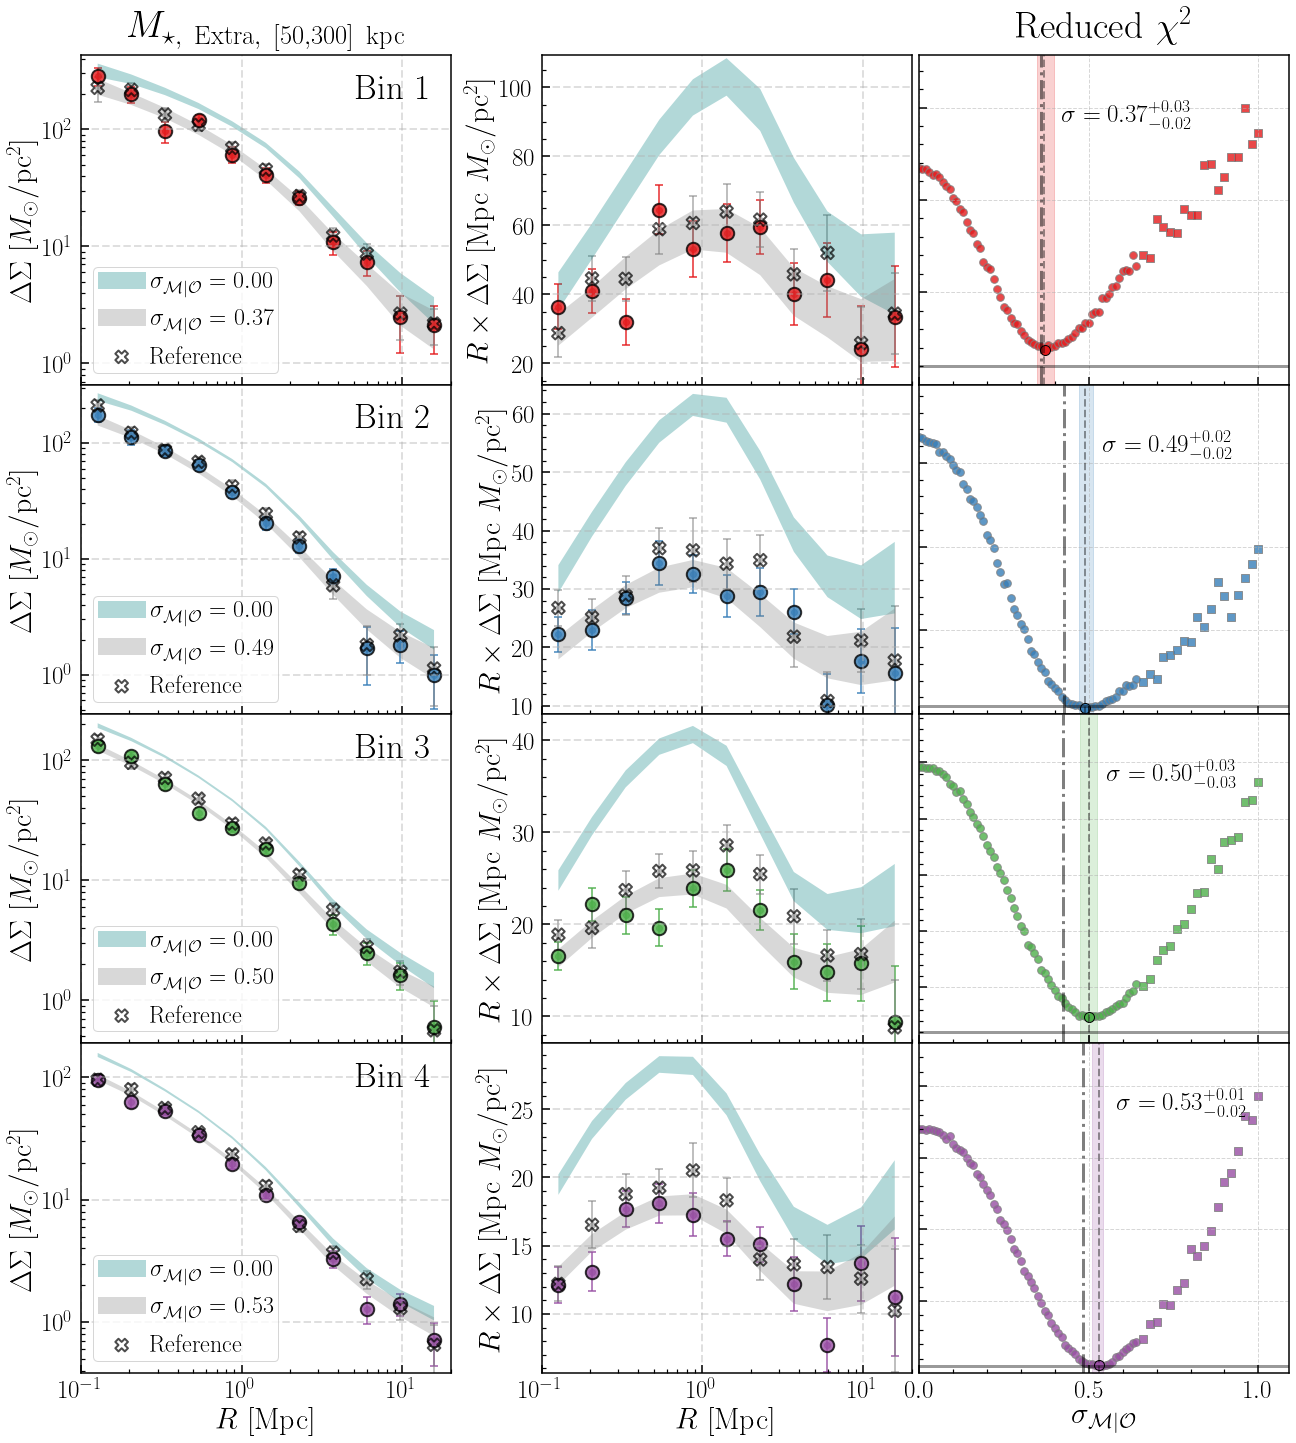

In [342]:
topn_m50_300_extra = wlensing.gather_topn_dsigma_profiles(
    hsc_good, s16a_rand, topn_bins, 'logm_50_300_extra', n_rand=200000, n_boot=200, verbose=False, n_jk=40)

topn_m50_300_extra_sum = scatter.compare_model_dsigma(
    topn_m50_300_extra, sim_cat, model_err=True, poly=True, verbose=False)

fig = visual.sum_plot_topn(
    topn_m50_300_extra_sum, r'$M_{\star,\ \rm Extra,\ [50, 300]\ \rm kpc}$', note=None, cov_type='jk', 
    ref_tab=topn_m50_100_sum)